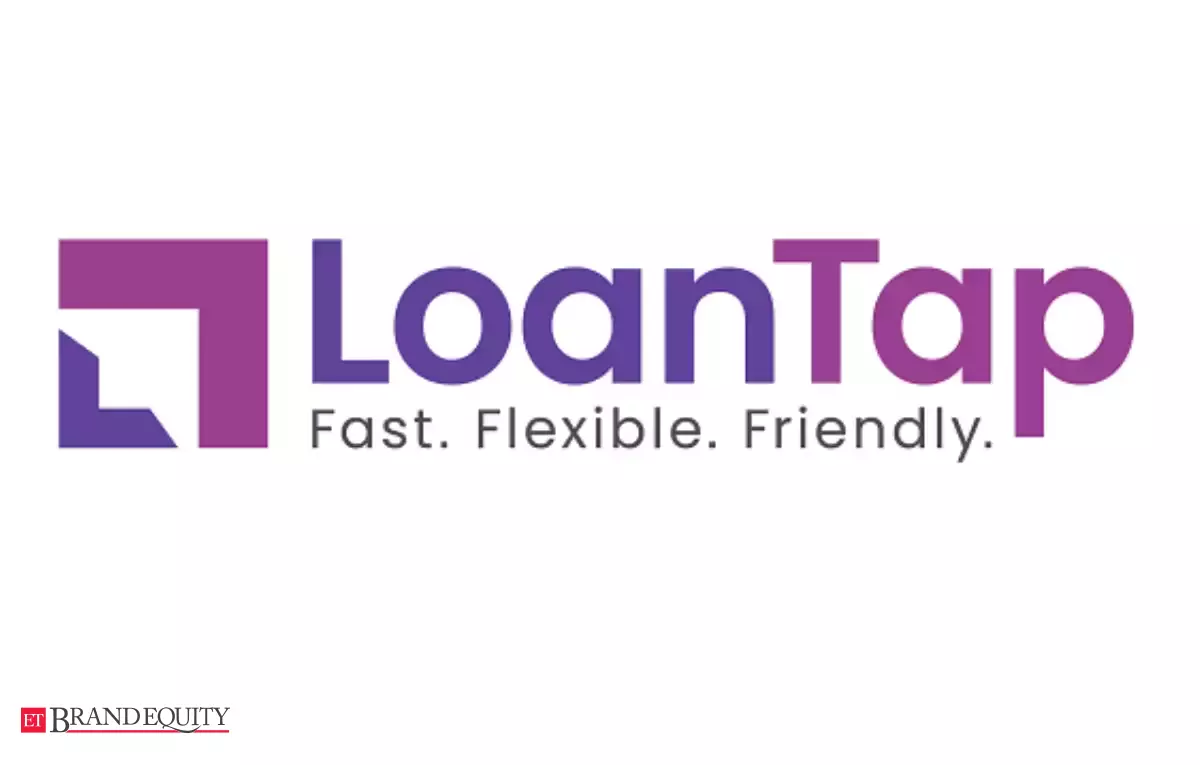

**LoanTap** is an online platform committed to delivering customized loan products to millennials. They innovate in an otherwise dull loan segment, to deliver instant, flexible loans on consumer friendly terms to salaried professionals and businessmen.



---


The data science team at LoanTap is building an underwriting layer to determine the creditworthiness of MSMEs as well as individuals.


---




LoanTap deploys formal credit to salaried individuals and businesses 4 main financial instruments:

- Personal Loan
- EMI Free Loan
- Personal Overdraft
- Advance Salary Loan


This case study will focus on the underwriting process behind Personal Loan only

# Column Profiling :

- loan_amnt: Amount borrower applied for.
- term: Loan duration (36 or 60 months).
- int_rate: Interest rate on loan.
- installment: Monthly repayment amount.
- grade: LoanTap assigned loan grade (Risk ratings by LoanTap.)
- sub_grade: LoanTap assigned loan grade (Risk ratings by LoanTap.)
- emp_title: Borrower's job title.
- emp_length: Duration of borrower's employment (0-10 years).
- home_ownership: Borrower's housing situation (own, rent, etc.).
- annual_inc: Borrower's yearly income.
- verification_status: Whether borrower's income was verified.
- issue_d: Loan issuance month.
- loan_status: Current status of the loan.
- purpose: Borrower's reason for the loan.
- title: The loan's title provided by the borrower.
- dti (Debt-to-Income ratio): Monthly debt vs. monthly income ratio.
- earliest_cr_line: Date of borrower's oldest credit account.
- open_acc: Number of borrower's active credit lines.
- pub_rec: Negative records on borrower's public credit profile.
- revol_bal: Total credit balance.
- revol_util: Usage percentage of 'revolving' accounts like credit cards.
- total_acc: Total number of borrower's credit lines.
- initial_list_status: Loan's first category ('W' or 'F').
- application_type: Individual or joint application.
- mort_acc: Number of borrower's mortgages.
- pub_rec_bankruptcies: Bankruptcy records for borrower.
- Address: Borrower's location.

In [346]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind,chi2_contingency

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score,
    ConfusionMatrixDisplay, RocCurveDisplay,f1_score,recall_score,precision_score
)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [347]:
!gdown 1ZPYj7CZCfxntE8p2Lze_4QO4MyEOy6_d -O "loan.csv"

Downloading...
From: https://drive.google.com/uc?id=1ZPYj7CZCfxntE8p2Lze_4QO4MyEOy6_d
To: /content/loan.csv
100% 100M/100M [00:00<00:00, 167MB/s] 


In [348]:
data = pd.read_csv("loan.csv") # Reading the data

In [349]:
data.head(3)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"


In [350]:
data.shape # Shape of the data

(396030, 27)

In [351]:
data.info()  # Exploring the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

In [352]:
pd.set_option('display.max_columns', None) # View all the columns

In [353]:
data.head() # Top 5 rows from the data

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


# Null Detection

In [354]:
data.isnull().sum().sort_values(ascending = False)

,0
mort_acc,37795
emp_title,22927
emp_length,18301
title,1756
pub_rec_bankruptcies,535
revol_util,276
loan_amnt,0
dti,0
application_type,0
initial_list_status,0


In [355]:
missing_data_per = ((data.isnull().sum().sort_values(ascending = False) / data.shape[0])*100).reset_index()
missing_data_per.columns = ["Column_name" , "Missing_data_percentage"]
missing_data_per[missing_data_per["Missing_data_percentage"] > 0]

,Column_name,Missing_data_percentage
0,mort_acc,9.543469
1,emp_title,5.789208
2,emp_length,4.621115
3,title,0.443401
4,pub_rec_bankruptcies,0.135091
5,revol_util,0.069692


## Insights :

- mort_acc (9.54%): Significant missing data, may require imputation or handling strategies.
- emp_title (5.79%): Moderate missing data, consider imputation based on job roles or titles.
- emp_length (4.62%): Missing data can be imputed or marked as unknown for employment length.
- title (0.44%): Low missing data, minimal impact on analysis.
- pub_rec_bankruptcies (0.14%): Very low missing data, likely can be ignored or imputed.
- revol_util (0.07%): Negligible missing data, can be easily handled with imputation if needed.

#Duplicate Detection

In [356]:
data.duplicated().sum()

0

## Insights :
- This dataset does not contain any duplicate value

# Unique Values and Counts

In [357]:
for i in data.columns:
  print(f"Column {i} Unique Value Count :  {data[i].nunique()}\n")
  print(f"Column {i} Unique Values :  {data[i].unique()}\n")
  print(f"Column {i} Value Counts :  {data[i].value_counts()}\n")
  print("-"*80)


Column loan_amnt Unique Value Count :  1397

Column loan_amnt Unique Values :  [10000.  8000. 15600. ... 36275. 36475.   725.]

Column loan_amnt Value Counts :  loan_amnt
10000.0    27668
12000.0    21366
15000.0    19903
20000.0    18969
35000.0    14576
           ...  
36225.0        1
950.0          1
37800.0        1
30050.0        1
725.0          1
Name: count, Length: 1397, dtype: int64

--------------------------------------------------------------------------------
Column term Unique Value Count :  2

Column term Unique Values :  [' 36 months' ' 60 months']

Column term Value Counts :  term
36 months    302005
60 months     94025
Name: count, dtype: int64

--------------------------------------------------------------------------------
Column int_rate Unique Value Count :  566

Column int_rate Unique Values :  [11.44 11.99 10.49  6.49 17.27 13.33  5.32 11.14 10.99 16.29 13.11 14.64
  9.17 12.29  6.62  8.39 21.98  7.9   6.97  6.99 15.61 11.36 13.35 12.12
  9.99  8.19 18.75  6.

# Converstion Of Date Time Column

In [358]:
data["issue_d"] = pd.to_datetime(data["issue_d"])
data["earliest_cr_line"] = pd.to_datetime(data["earliest_cr_line"])

In [359]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   loan_amnt             396030 non-null  float64       
 1   term                  396030 non-null  object        
 2   int_rate              396030 non-null  float64       
 3   installment           396030 non-null  float64       
 4   grade                 396030 non-null  object        
 5   sub_grade             396030 non-null  object        
 6   emp_title             373103 non-null  object        
 7   emp_length            377729 non-null  object        
 8   home_ownership        396030 non-null  object        
 9   annual_inc            396030 non-null  float64       
 10  verification_status   396030 non-null  object        
 11  issue_d               396030 non-null  datetime64[ns]
 12  loan_status           396030 non-null  object        
 13 

# Imputing Null Values

In [360]:
missing_columns = missing_data_per[missing_data_per["Missing_data_percentage"] > 0]["Column_name"].values

In [361]:
num_col = []
cat_col = []
for i in missing_columns:
  if data[i].dtype == "object":
    cat_col.append(i)
  elif data[i].dtype == "float64":
    num_col.append(i)

cat_col.remove("emp_title")

In [362]:
data['emp_title'] = data['emp_title'].fillna("Not Available")

In [363]:
from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy = "most_frequent")

In [364]:
data[num_col] = num_imputer.fit_transform(data[num_col])
data[cat_col] = cat_imputer.fit_transform(data[cat_col])

In [365]:
data.isnull().sum()

,0
loan_amnt,0
term,0
int_rate,0
installment,0
grade,0
sub_grade,0
emp_title,0
emp_length,0
home_ownership,0
annual_inc,0


# Data Statistics

In [366]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
loan_amnt,396030.0,14113.888089,500.0,8000.0,12000.0,20000.0,40000.0,8357.441341
int_rate,396030.0,13.6394,5.32,10.49,13.33,16.49,30.99,4.472157
installment,396030.0,431.849698,16.08,250.33,375.43,567.3,1533.81,250.72779
annual_inc,396030.0,74203.175798,0.0,45000.0,64000.0,90000.0,8706582.0,61637.621158
issue_d,396030,2014-02-02 15:57:58.045602560,2007-06-01 00:00:00,2013-05-01 00:00:00,2014-04-01 00:00:00,2015-03-01 00:00:00,2016-12-01 00:00:00,NaN
dti,396030.0,17.379514,0.0,11.28,16.91,22.98,9999.0,18.019092
earliest_cr_line,396030,1998-05-03 09:34:15.062495488,1944-01-01 00:00:00,1994-10-01 00:00:00,1999-09-01 00:00:00,2003-04-01 00:00:00,2013-10-01 00:00:00,NaN
open_acc,396030.0,11.311153,0.0,8.0,10.0,14.0,90.0,5.137649
pub_rec,396030.0,0.178191,0.0,0.0,0.0,0.0,86.0,0.530671
revol_bal,396030.0,15844.539853,0.0,6025.0,11181.0,19620.0,1743266.0,20591.836109


In [367]:
data.describe(include = "object").T

,count,unique,top,freq
term,396030,2,36 months,302005
grade,396030,7,B,116018
sub_grade,396030,35,B3,26655
emp_title,396030,173106,Not Available,22927
emp_length,396030,11,10+ years,144342
home_ownership,396030,6,MORTGAGE,198348
verification_status,396030,3,Verified,139563
loan_status,396030,2,Fully Paid,318357
purpose,396030,14,debt_consolidation,234507
title,396030,48816,Debt consolidation,154228


## Insights :

- Loan Amount and Terms: Average loan amount is 14,114 with most loans ranging between 8,000 and 20,000. Most loans have a 36-month term.

- Interest Rate and Installments: Average interest rate is 13.64%, with monthly installments averaging $431.85, showing significant variation based on loan size.

- Income and DTI: Average annual income is $74,203, but with high variance. The average debt-to-income ratio is 17.38%, with some extreme outliers.

- Credit History: On average, borrowers have 11 open accounts. Public records (e.g., bankruptcies) are rare, with an average of 0.18.

- Loan Purpose and Employment: Most loans are for debt consolidation. The most common job title is Teacher, with many borrowers having 10+ years of employment.

# Data Visualization

In [368]:
num_col2 = data.select_dtypes(include=np.number).columns
num_col2

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc',
       'pub_rec_bankruptcies'],
      dtype='object')

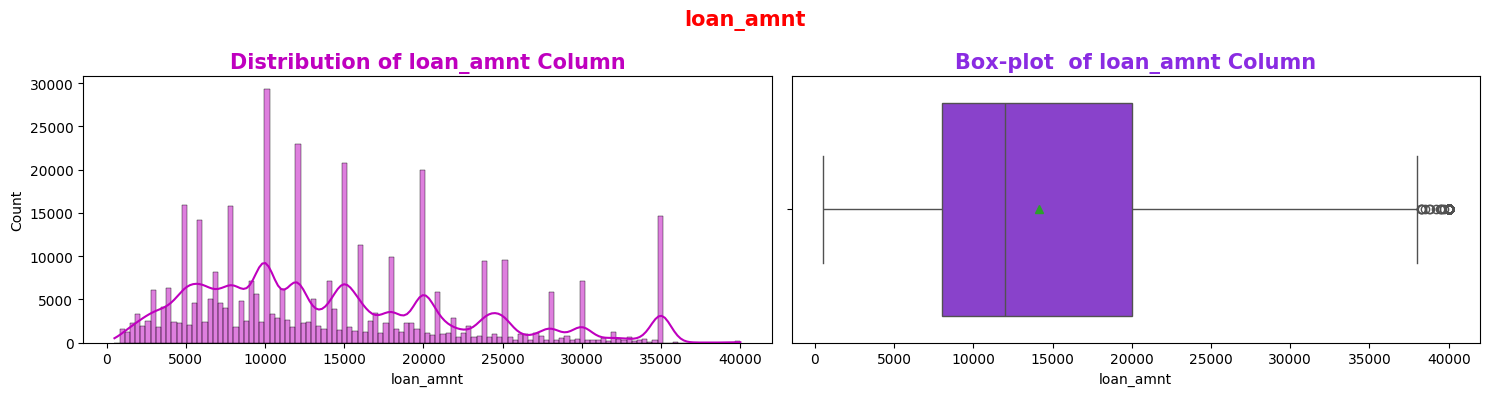

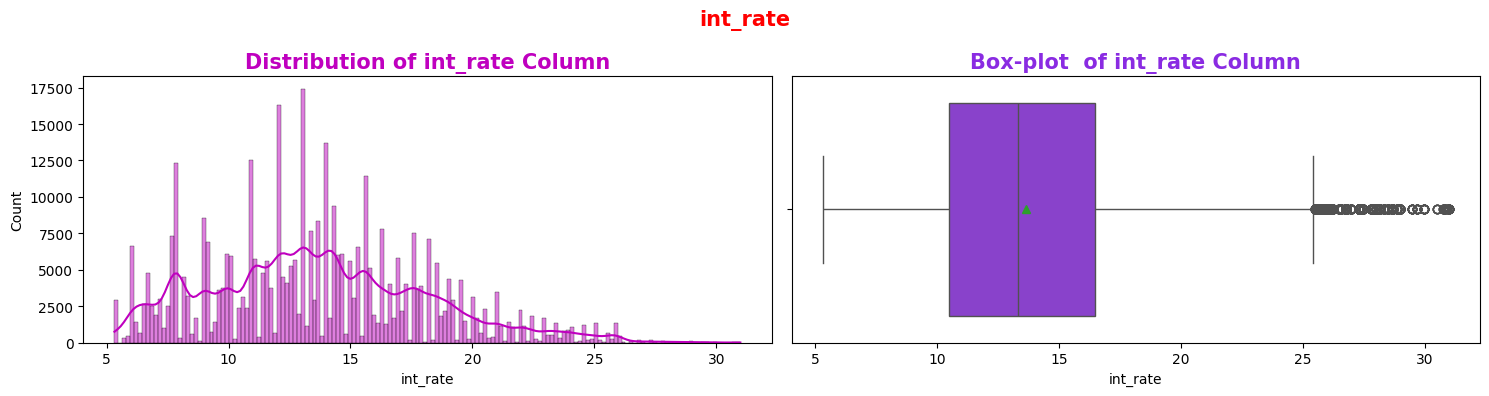

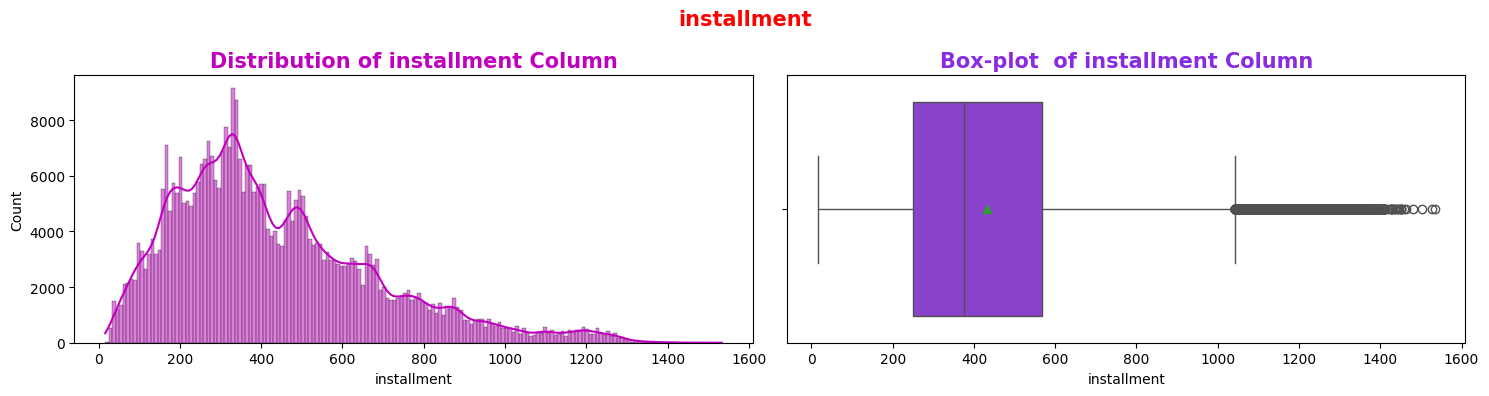

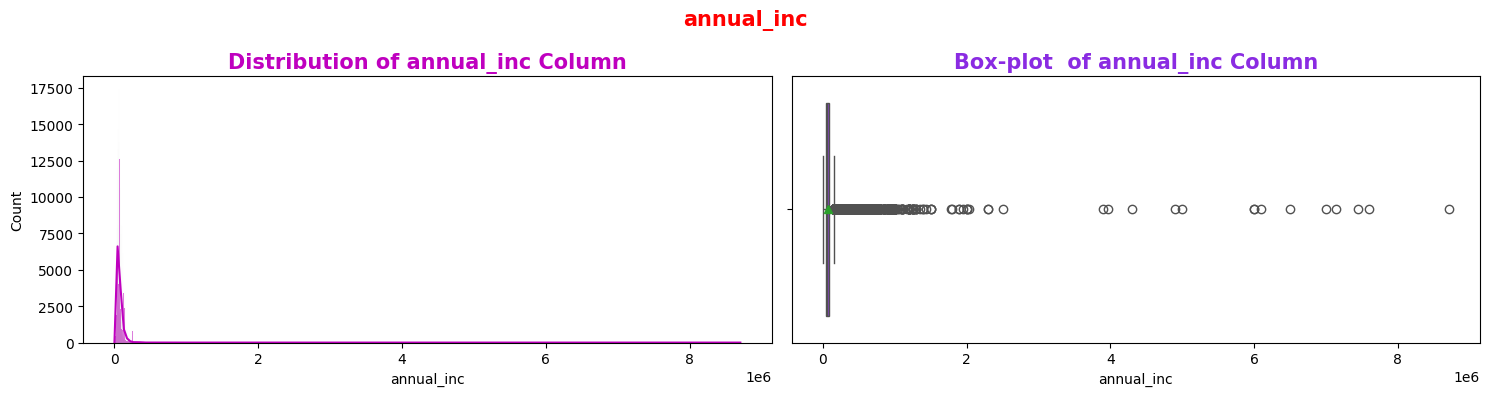

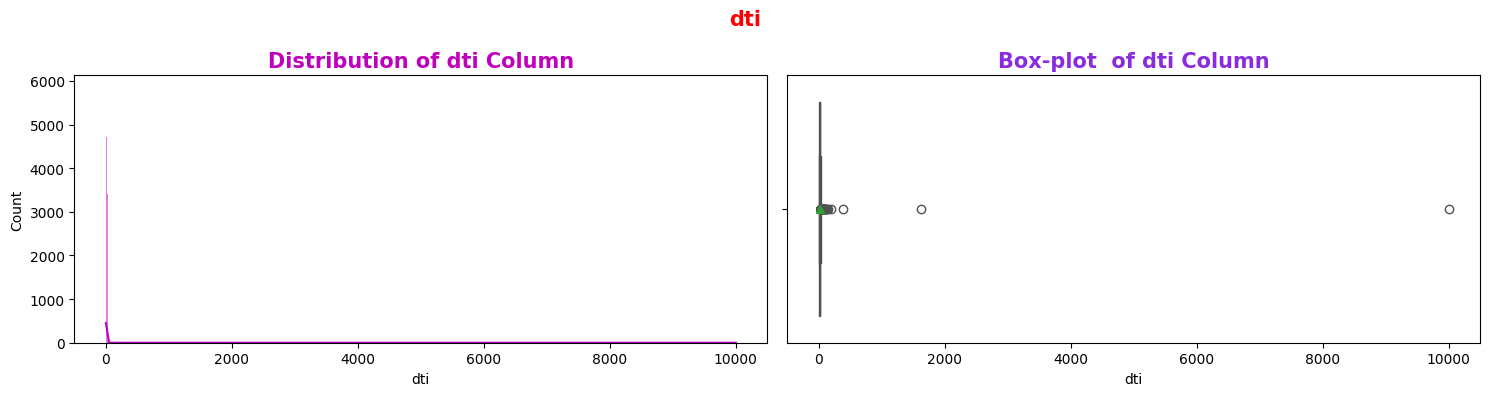

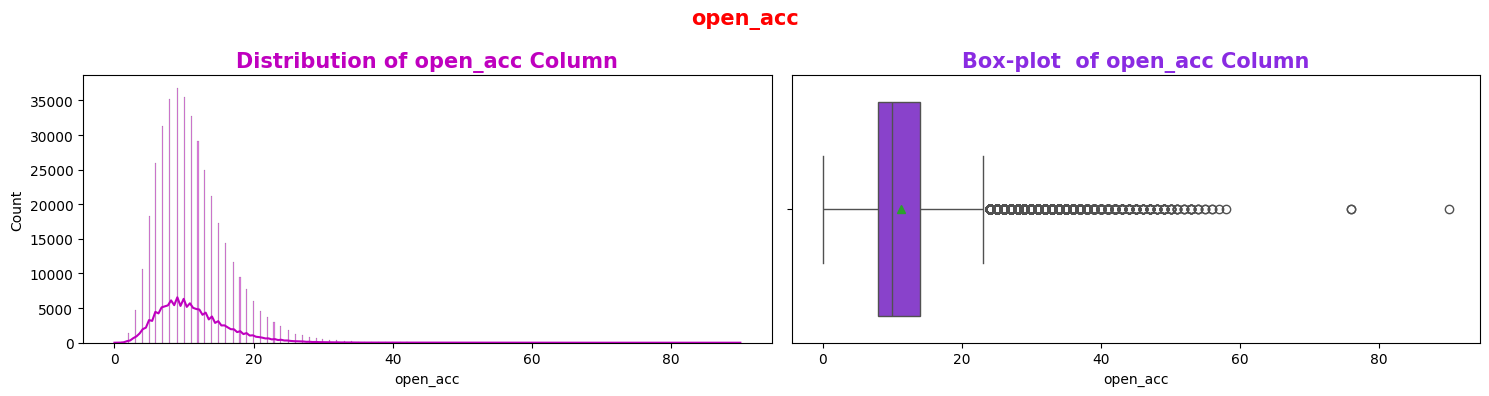

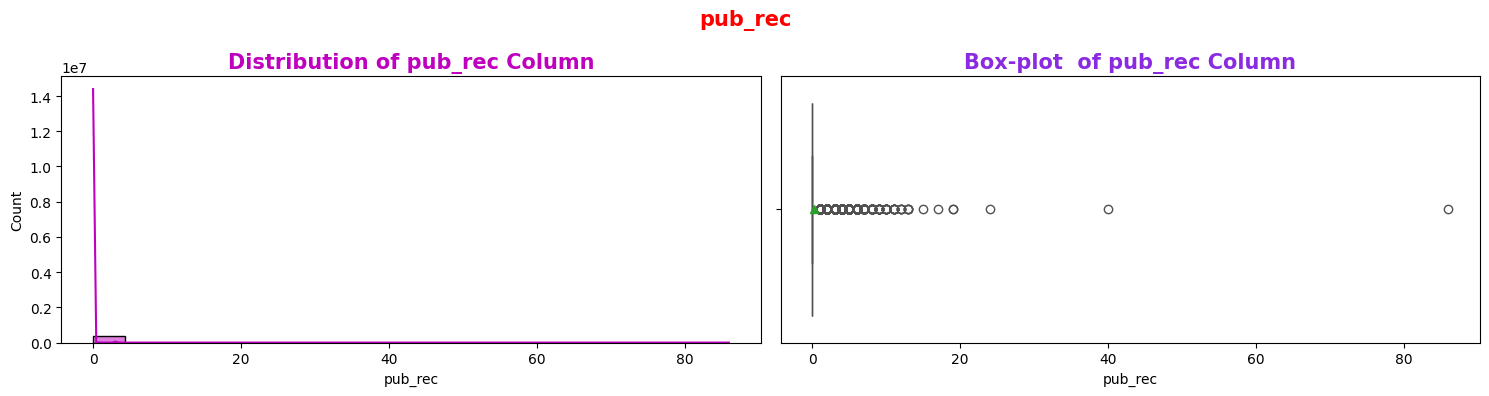

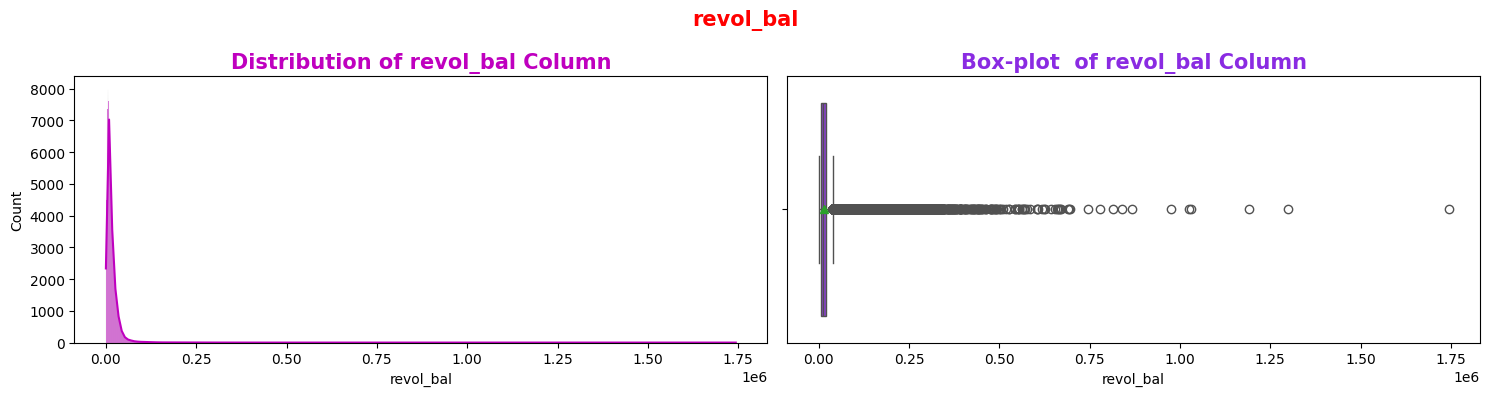

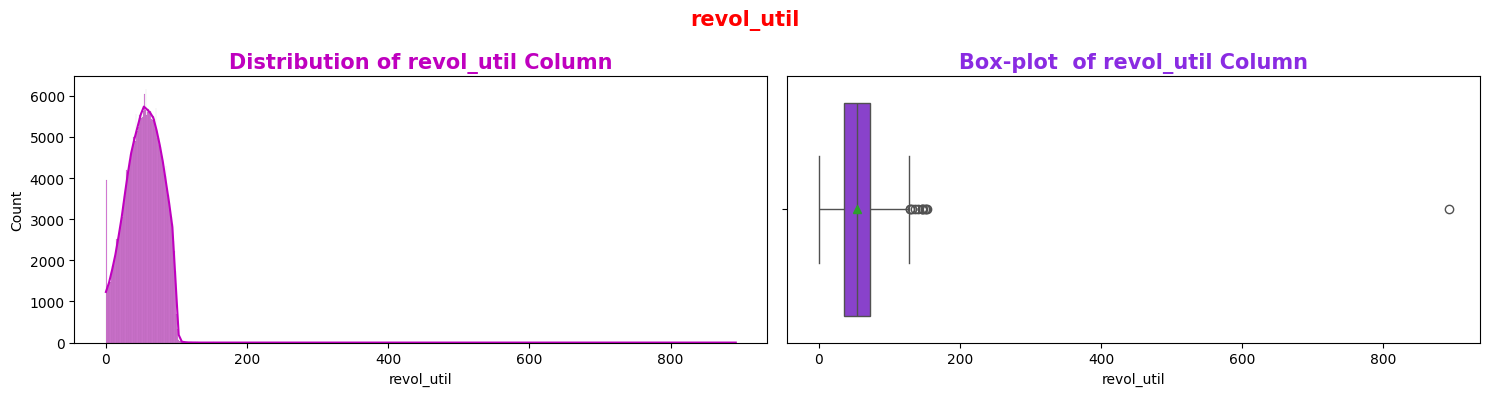

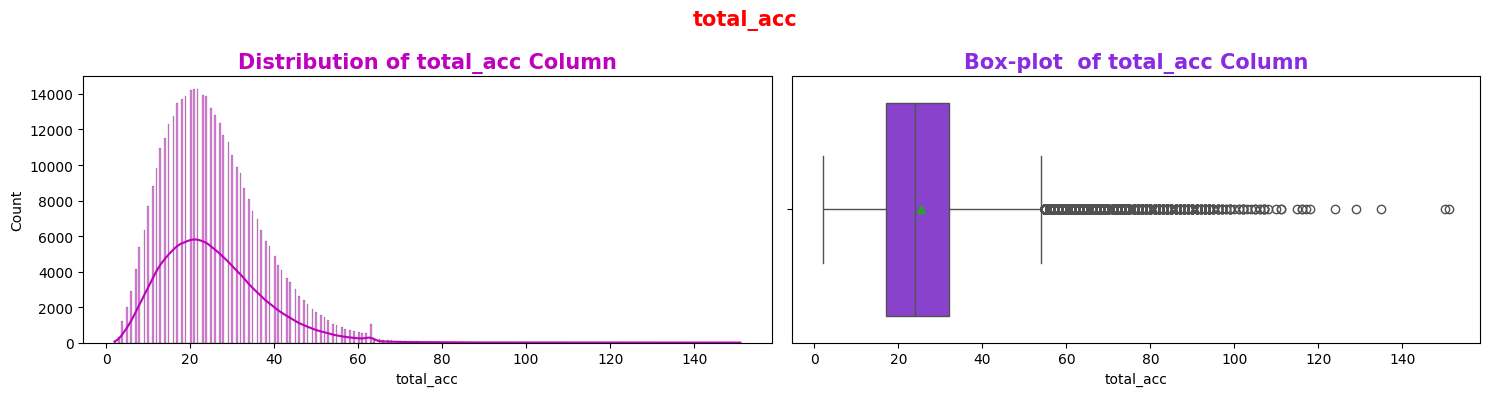

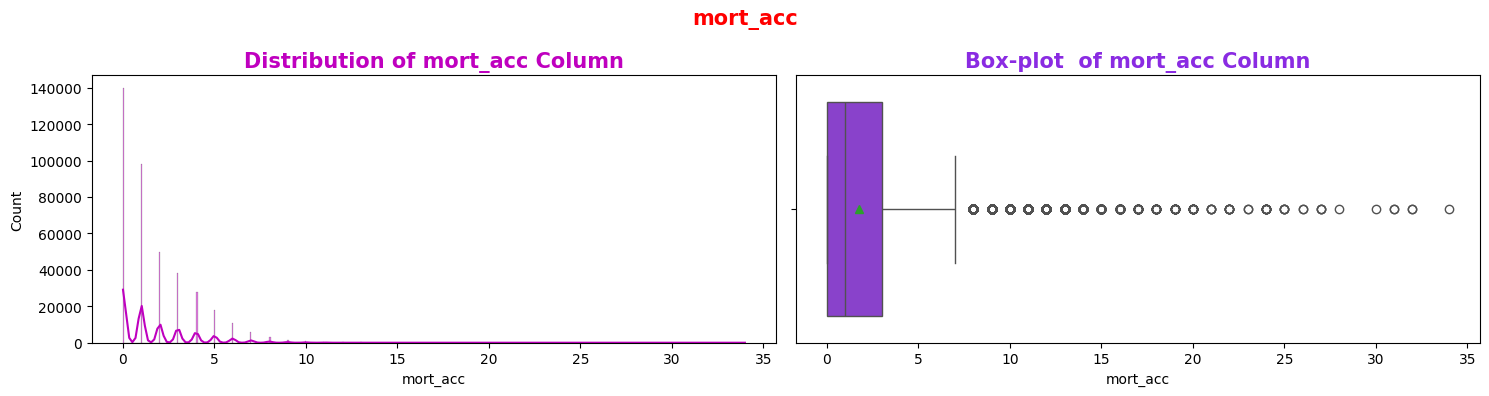

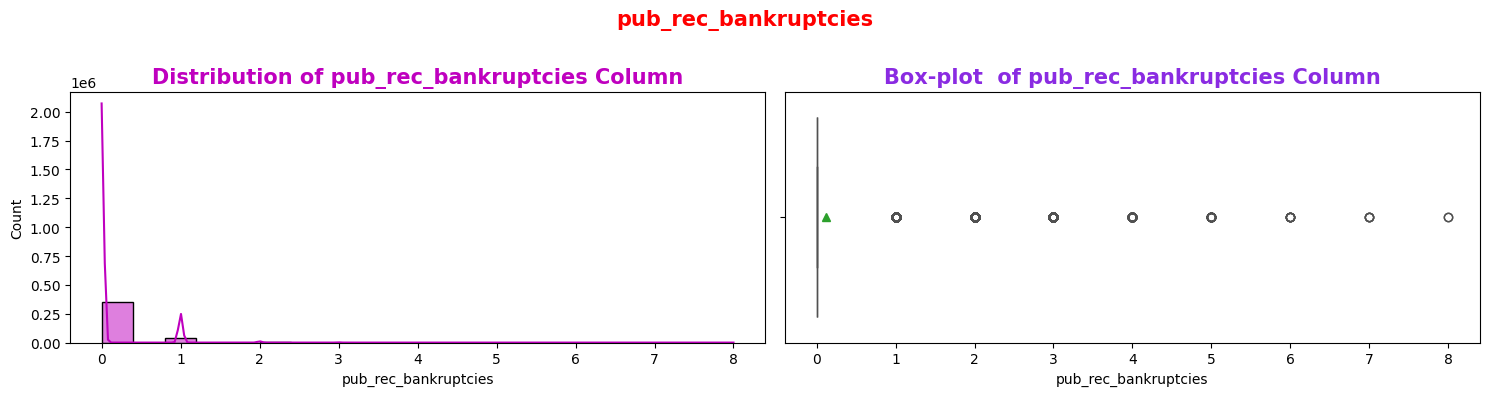

In [369]:
for i in num_col2:
  plt.figure(figsize=(15,4))
  plt.subplot(1,2,1)
  sns.histplot(x = data[i],kde = True,color = "m")
  plt.title(f'Distribution of {i} Column',fontsize=15,fontweight='bold',color='m')
  plt.subplot(1,2,2)
  sns.boxplot(x = data[i],color ="blueviolet",showmeans = True)
  plt.title(f'Box-plot  of {i} Column',fontsize=15,fontweight='bold',color='blueviolet')
  plt.suptitle(f'{i}',fontsize=15,fontweight='bold',color='r')
  plt.tight_layout()
  plt.show()

### Insights :

- The analysis indicates the presence of outliers, which requires further exploration using outlier detection methods.
- Several numerical features may still contain potential outliers that need closer examination.
- Features like pub_rec, mort_acc, and pub_rec_bankruptcies have a sparse distribution of unique values.
- It may be beneficial to create binary features from variables with sparse distributions, such as pub_rec, mort_acc, and pub_rec_bankruptcies.

In [370]:
data.head(3)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,2015-01-01,Fully Paid,vacation,Vacation,26.24,1990-06-01,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,2015-01-01,Fully Paid,debt_consolidation,Debt consolidation,22.05,2004-07-01,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,2015-01-01,Fully Paid,credit_card,Credit card refinancing,12.79,2007-08-01,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"


# Splitting Address Column

In [371]:
data["state"]  = data["address"].str.split().str[-2]
data["pincode"] =  data["address"].str.split().str[-1]

# Extracting Month Name From Issued Date Column

In [372]:
data["issued_d_month"] = data["issue_d"].dt.month_name() # Extracting Month Name from issued_date

# Q1. What percentage of customers have fully paid their Loan Amount?

In [373]:
round(data['loan_status'].value_counts(normalize=True)*100,2)

,proportion
loan_status,
Fully Paid,80.39
Charged Off,19.61


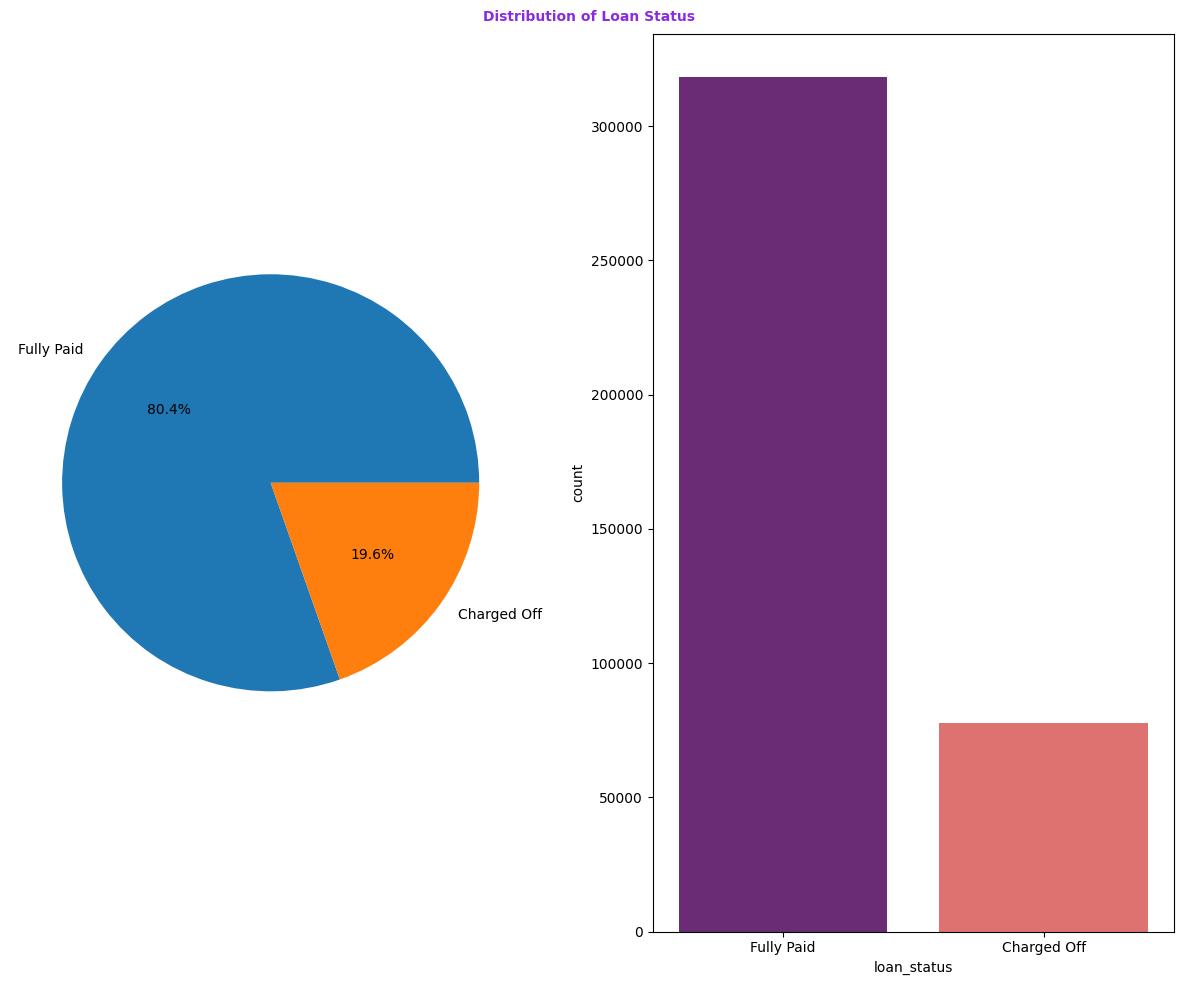

In [374]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.pie(x=data['loan_status'].value_counts().values, labels=data['loan_status'].value_counts().index,autopct='%1.1f%%')
 #explode=[0.0,0.1,0.1,0.1])
plt.suptitle('Distribution of Loan Status', fontsize=10, fontweight='bold',color='blueviolet')
plt.subplot(1,2,2)
sns.countplot(data = data , x = "loan_status",palette = "magma")
plt.tight_layout()
plt.show()

In [375]:
cat_col2 = ["term","grade","issued_d_month","pincode","verification_status","home_ownership"]

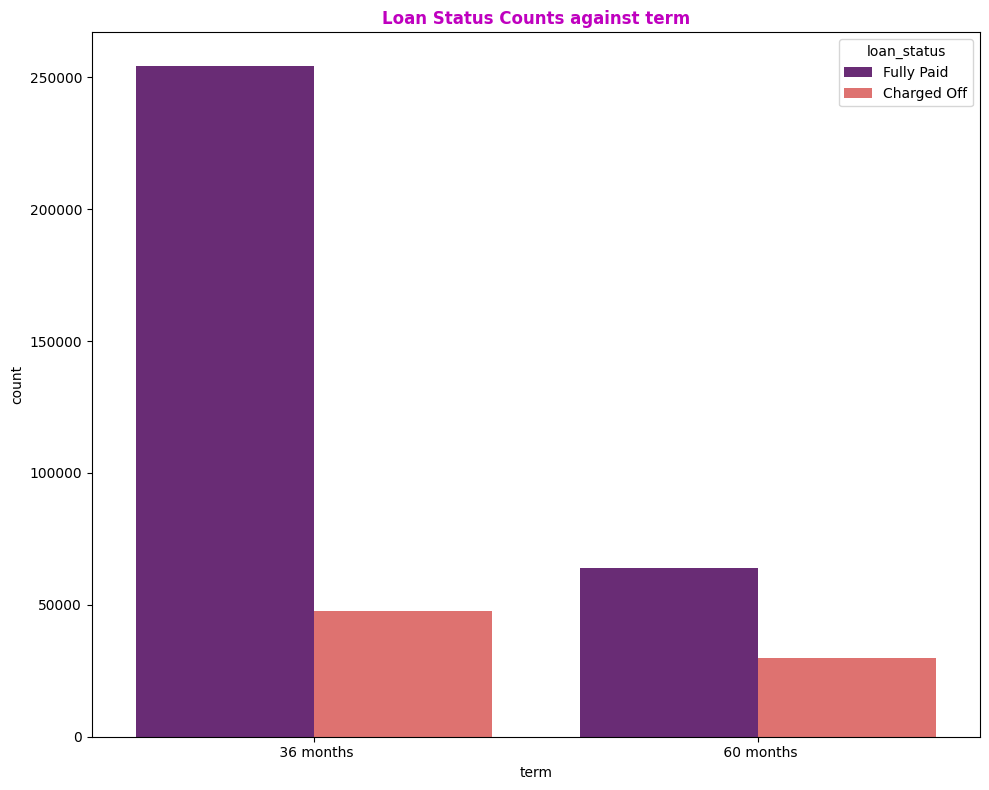

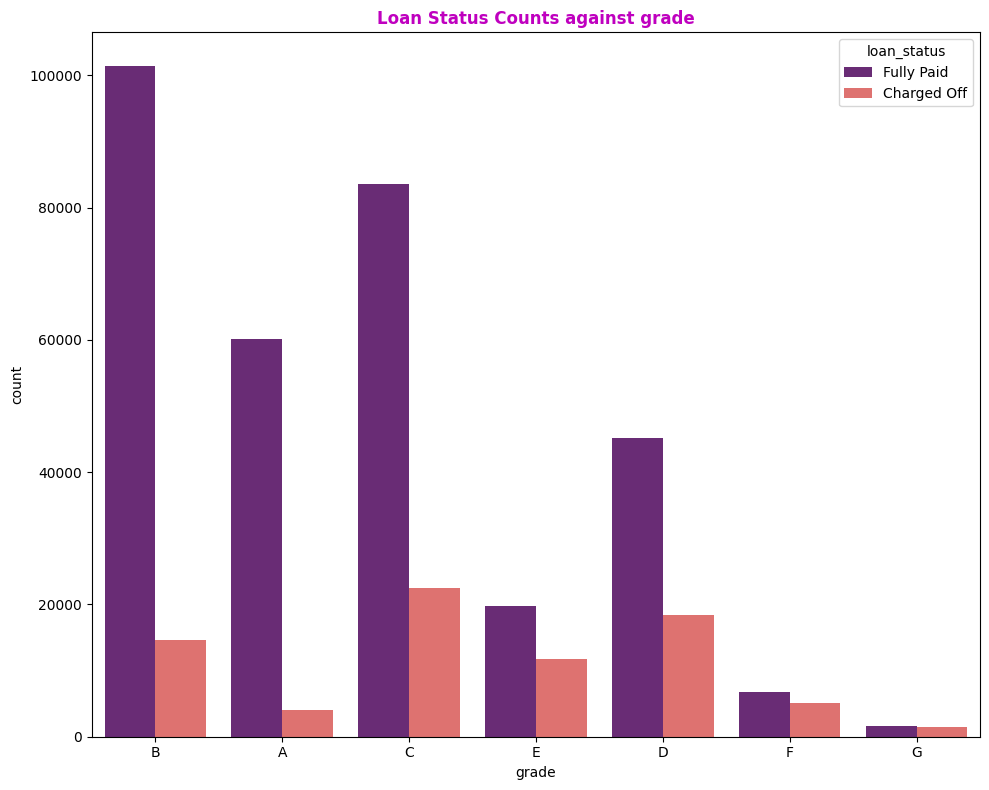

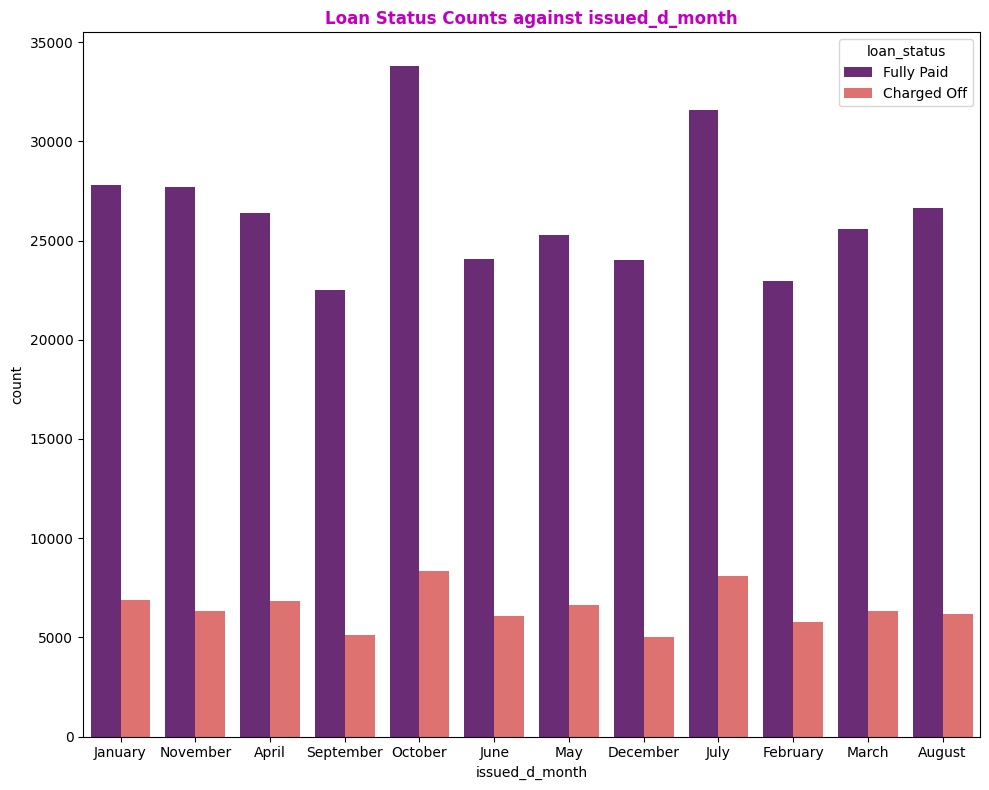

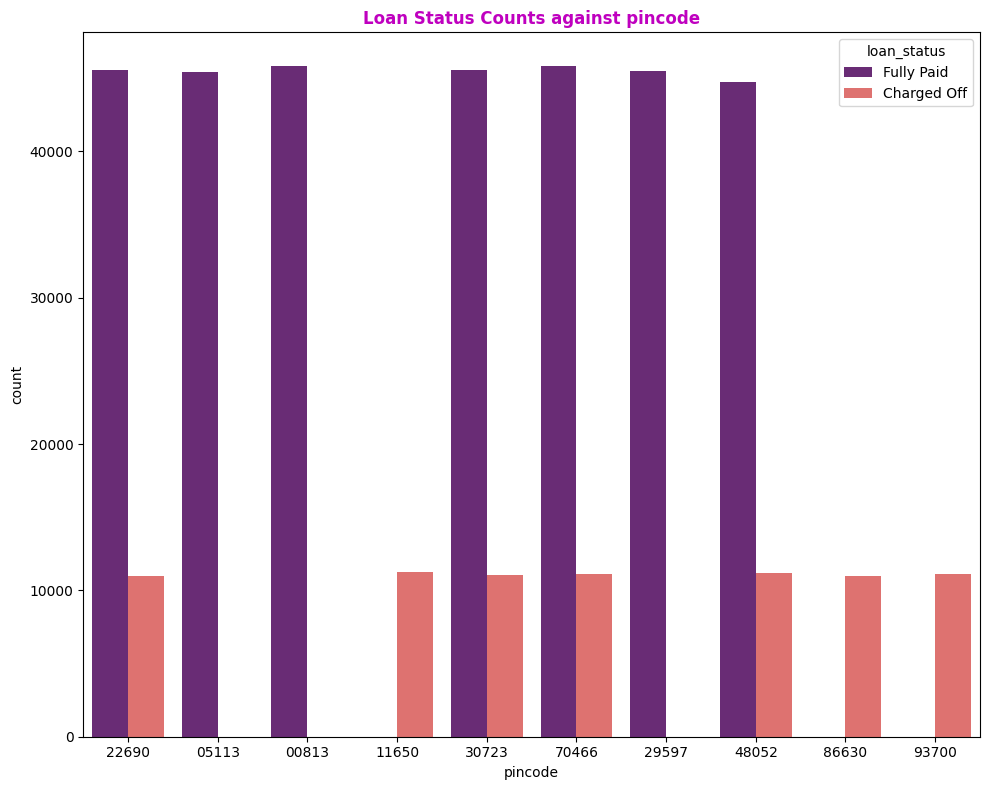

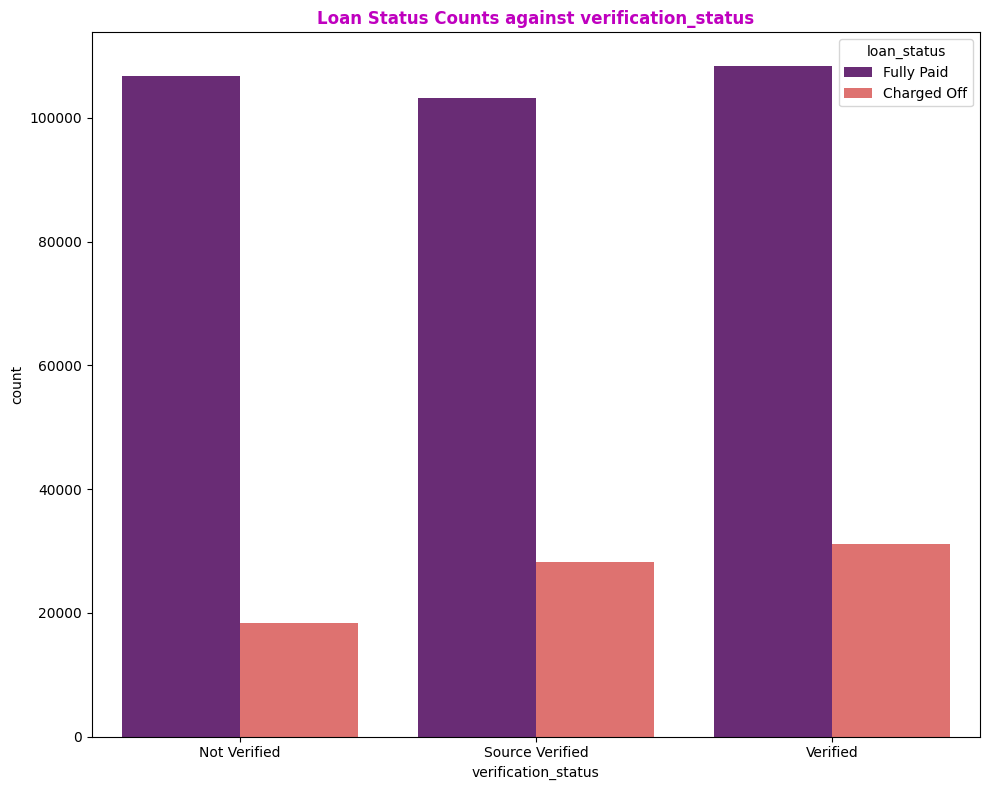

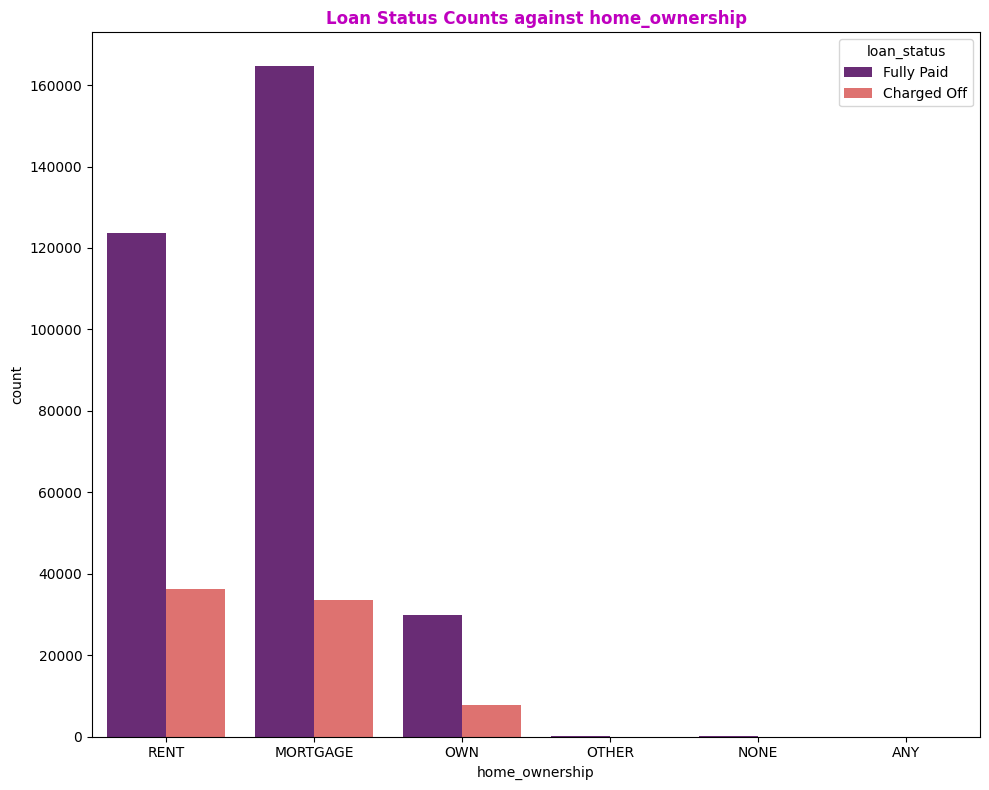

In [376]:
for  j in cat_col2:
  plt.figure(figsize=(10,8))
  sns.countplot(hue = data["loan_status"], x = data[j],palette = "magma")
  plt.title(f'Loan Status Counts against {j}',fontsize=12,fontweight='bold',color='m')
  plt.tight_layout()
  plt.show()

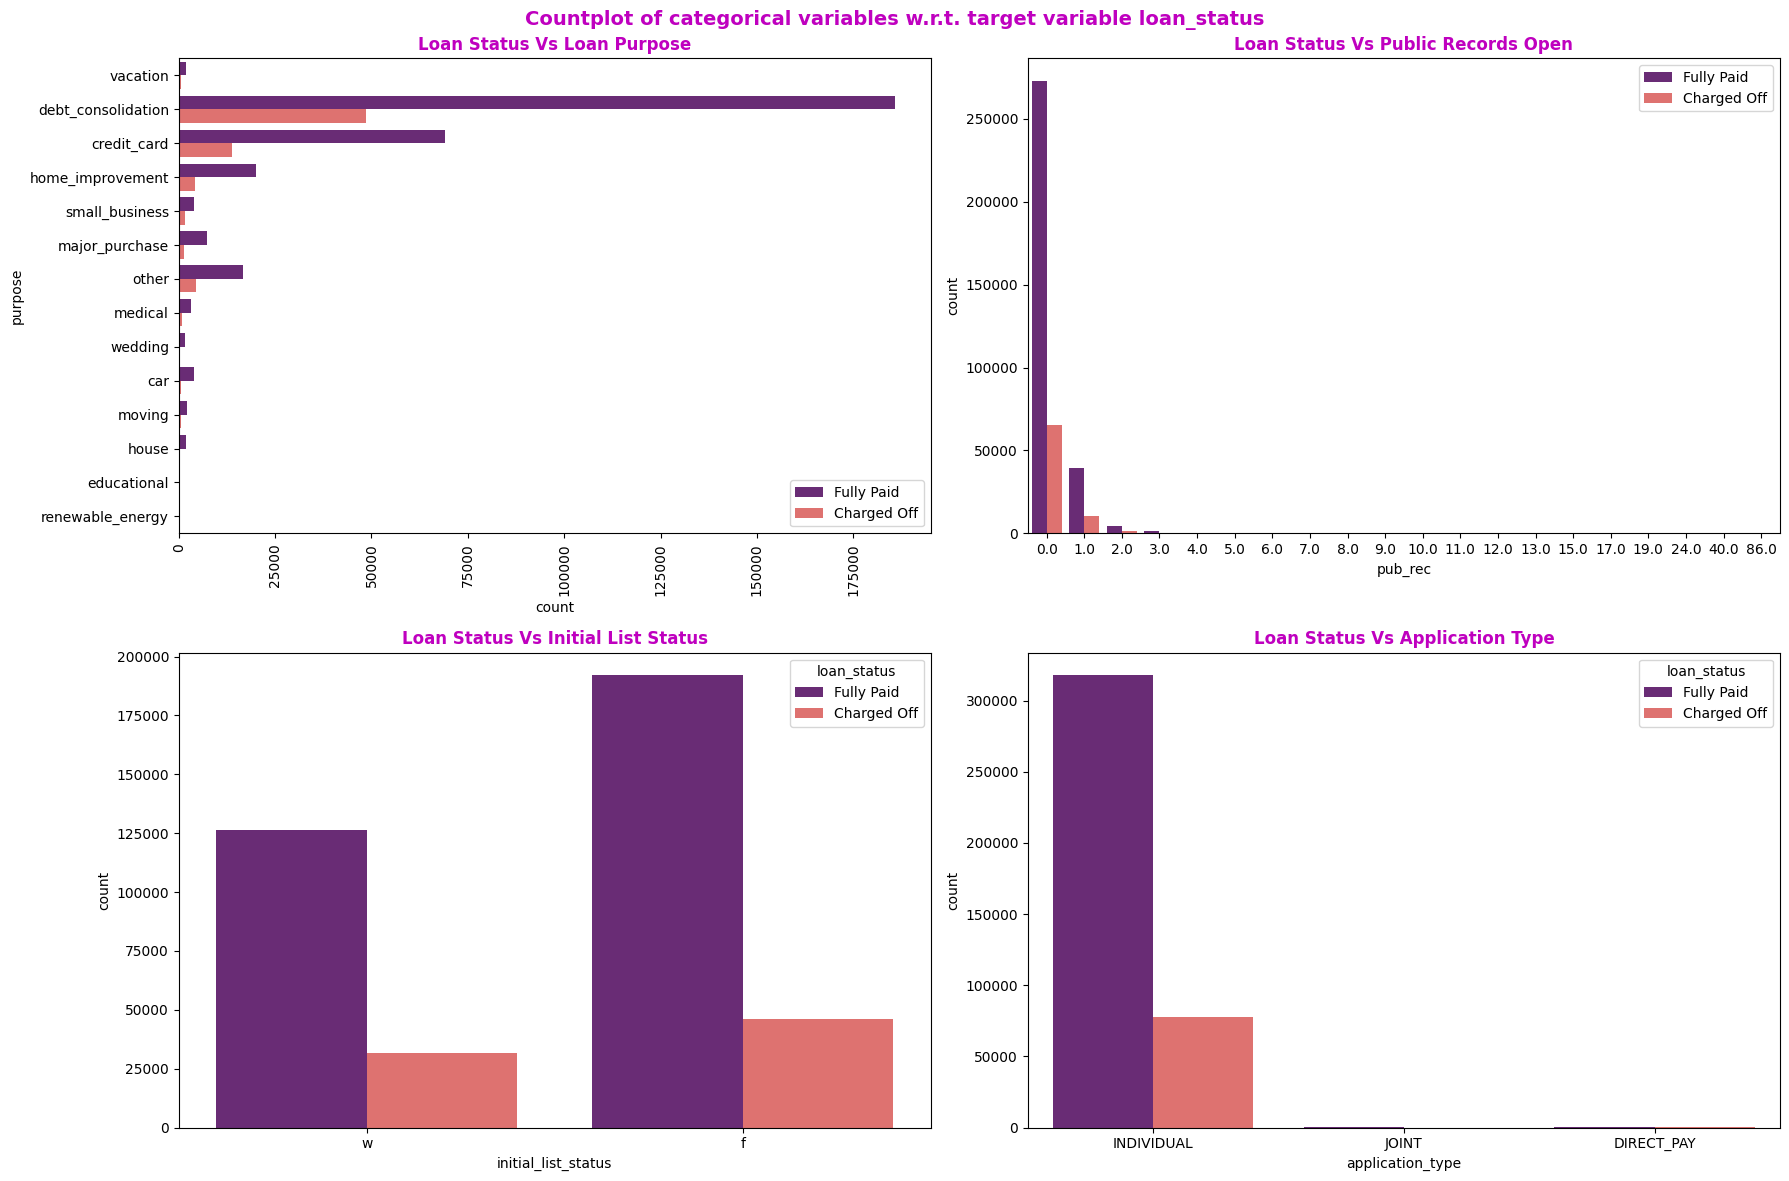

In [377]:
#Countplot of categorical variables w.r.t. target variable loan_status
plt.figure(figsize=(18,12))
plt.suptitle('Countplot of categorical variables w.r.t. target variable loan_status',
             fontsize=14,fontweight='bold',color='m')
plt.subplot(221)
sns.countplot(data=data, y='purpose', hue='loan_status',palette="magma")
plt.xticks(rotation=90)
plt.title('Loan Status Vs Loan Purpose',fontsize=12,fontweight='bold',color='m')
plt.legend(loc=4)
plt.subplot(222)
sns.countplot(data=data, x='pub_rec',hue='loan_status',palette="magma")
plt.title('Loan Status Vs Public Records Open',fontsize=12,fontweight='bold',color='m')
plt.legend(loc=1)
plt.subplot(223)
sns.countplot(data=data, x='initial_list_status', hue='loan_status',palette="magma")
plt.title('Loan Status Vs Initial List Status',fontsize=12,fontweight='bold',color='m')
plt.subplot(224)
sns.countplot(data=data, x='application_type',hue='loan_status',palette="magma")
plt.title('Loan Status Vs Application Type',fontsize=12,fontweight='bold',color='m')
plt.tight_layout()
plt.show()

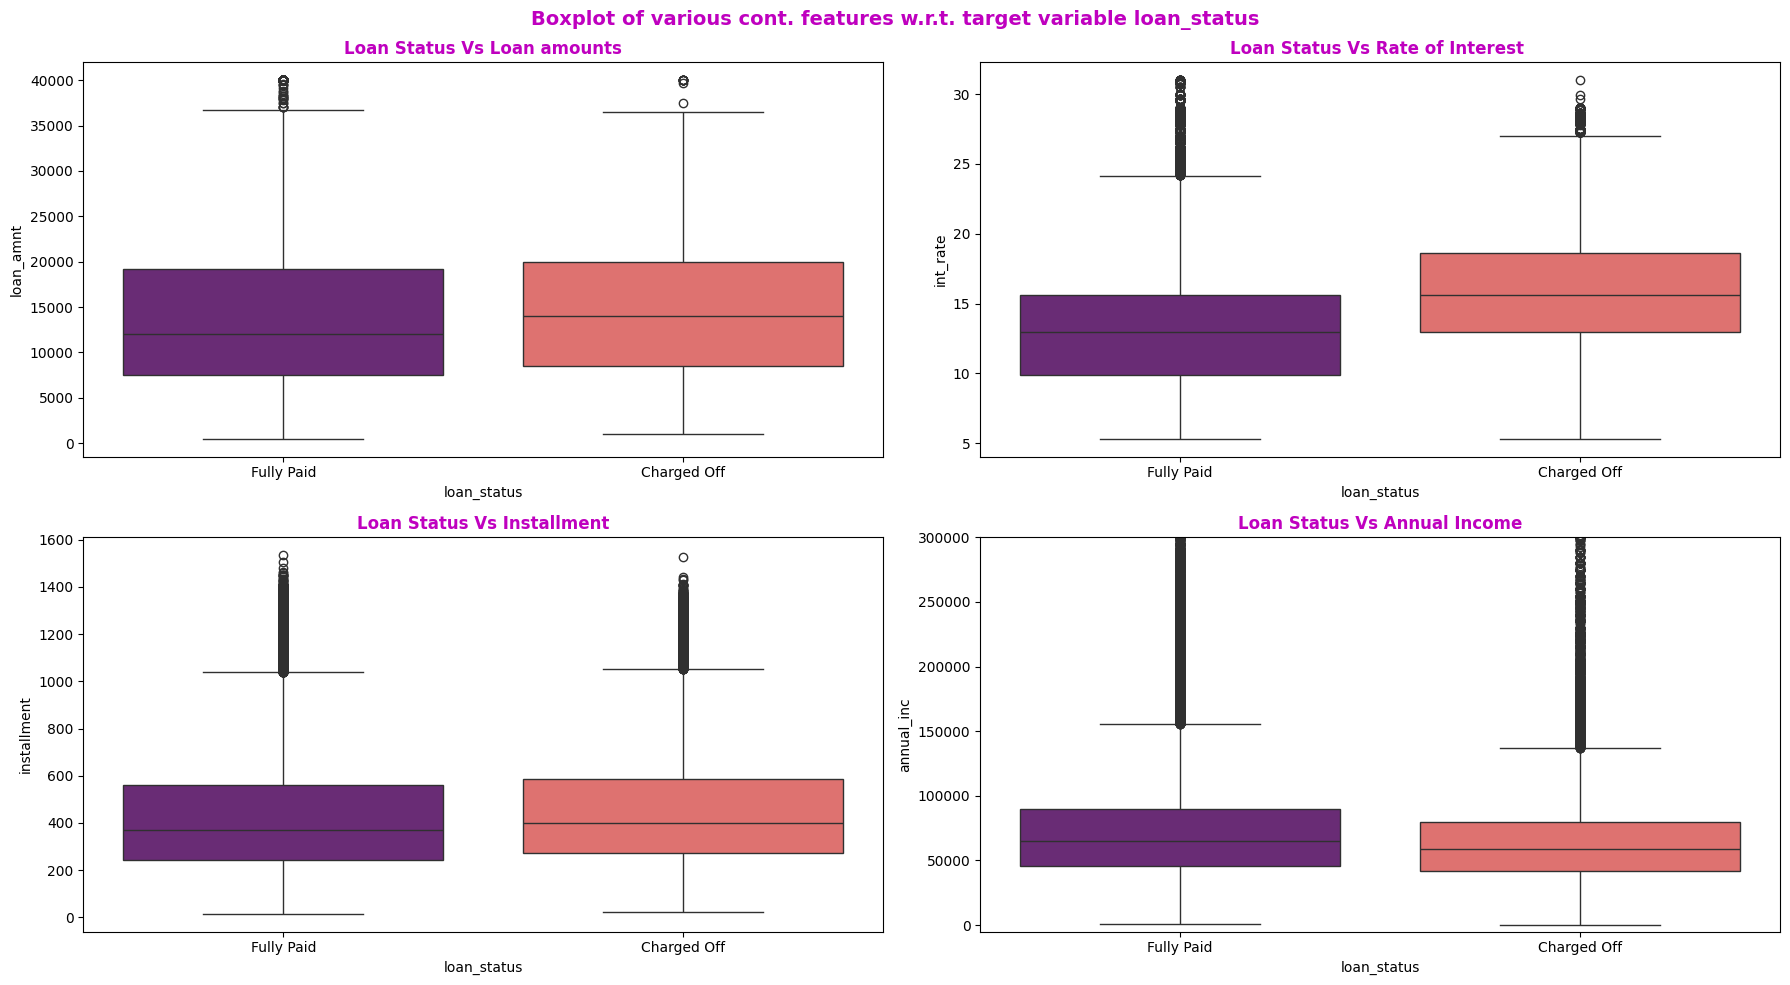

In [378]:
#Boxplot of various cont. features w.r.t. target variable loan_status
plt.figure(figsize=(18,10))
plt.suptitle('Boxplot of various cont. features w.r.t. target variable loan_status',
             fontsize=14,fontweight='bold',color='m')
plt.subplot(221)
sns.boxplot(data=data, x='loan_status', y='loan_amnt',palette="magma")
plt.title('Loan Status Vs Loan amounts',fontsize=12,fontweight='bold',color='m')
plt.subplot(222)
sns.boxplot(data=data, x='loan_status', y='int_rate',palette="magma")
plt.title('Loan Status Vs Rate of Interest ',fontsize=12,fontweight='bold',color='m')
plt.subplot(223)
sns.boxplot(data=data, x='loan_status', y='installment',palette="magma")
plt.title('Loan Status Vs Installment',fontsize=12,fontweight='bold',color='m')
plt.subplot(224)
sns.boxplot(data=data, x='loan_status', y='annual_inc',palette="magma")
plt.ylim(bottom=-5000, top=300000)
plt.title('Loan Status Vs Annual Income',fontsize=12,fontweight='bold',color='m')
plt.tight_layout()
plt.show()

## Insights :
- Customers with a Charged Off status tend to have a noticeably higher median interest rate and loan amount than those with a Fully Paid status.
- The median annual income and EMI are generally lower and higher, respectively, for Charged Off customers compared to Fully Paid customers.

In [379]:
data['emp_length'] = data['emp_length'].str.extract('(\d+)')


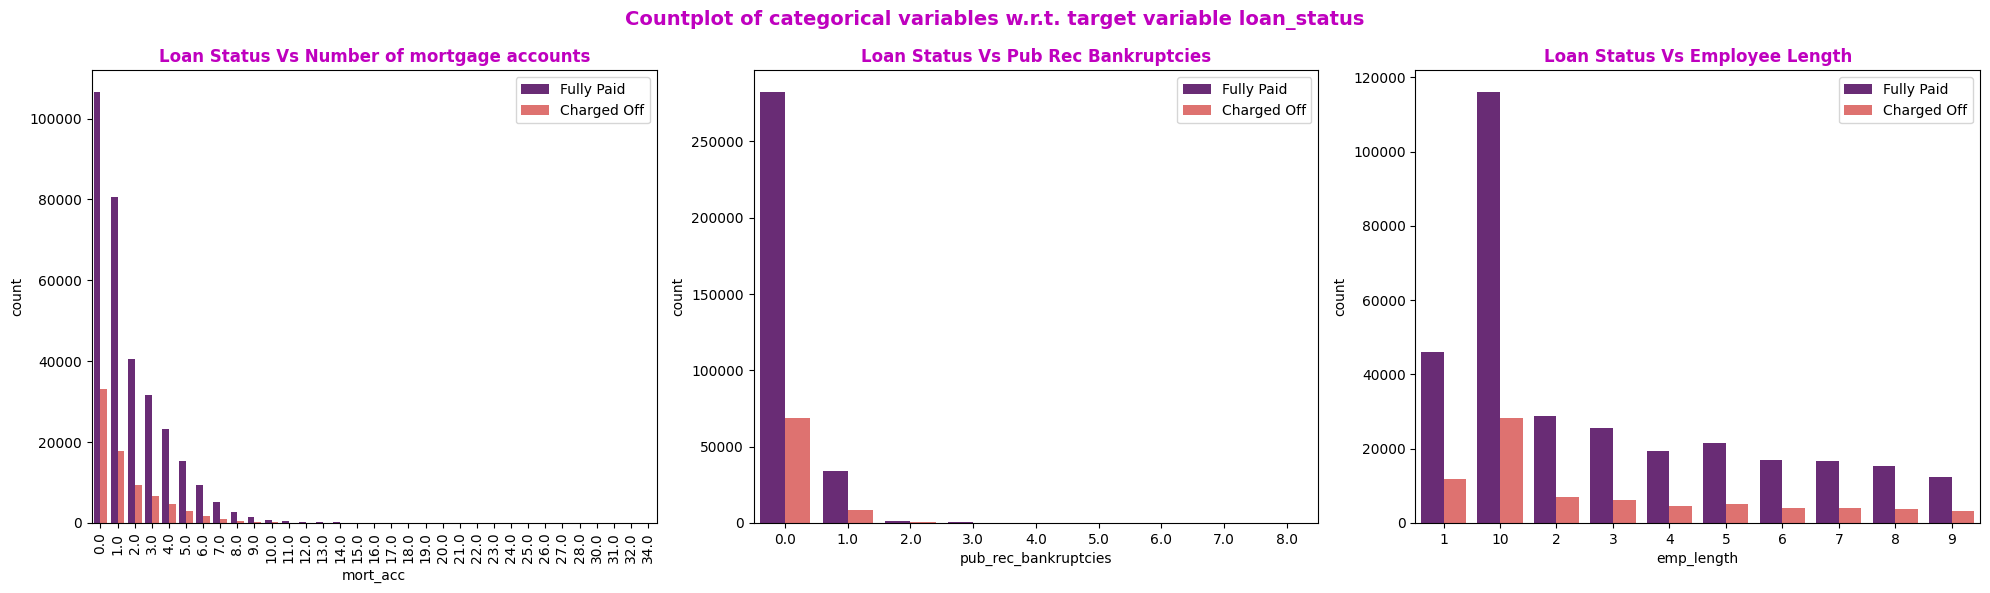

In [380]:
#Countplot for various categorical features w.r.t. target variable loan_status

plt.figure(figsize=(20,6))
plt.suptitle('Countplot of categorical variables w.r.t. target variable loan_status',
             fontsize=14,fontweight='bold',color='m')
plt.subplot(131)
sns.countplot(data=data, x='mort_acc',hue='loan_status',palette="magma")
plt.xticks(rotation=90)
plt.title('Loan Status Vs Number of mortgage accounts',fontsize=12,fontweight='bold',color='m')
plt.legend(loc=1)
plt.subplot(132)
sns.countplot(data=data, x='pub_rec_bankruptcies',hue='loan_status',palette="magma")
plt.title('Loan Status Vs Pub Rec Bankruptcies',fontsize=12,fontweight='bold',color='m')
plt.legend(loc=1)
plt.subplot(133)
order = sorted(data.emp_length.unique().tolist())
sns.countplot(data=data, x='emp_length',hue='loan_status',order=order,palette="magma")
plt.title('Loan Status Vs Employee Length',fontsize=12,fontweight='bold',color='m')
plt.legend(loc=1)
plt.tight_layout()
plt.show()

# Q2. Comment about the correlation between Loan Amount and Installment features.

In [381]:
data[['loan_amnt', 'installment']].corr()

,loan_amnt,installment
loan_amnt,1.000000,0.953929
installment,0.953929,1.000000


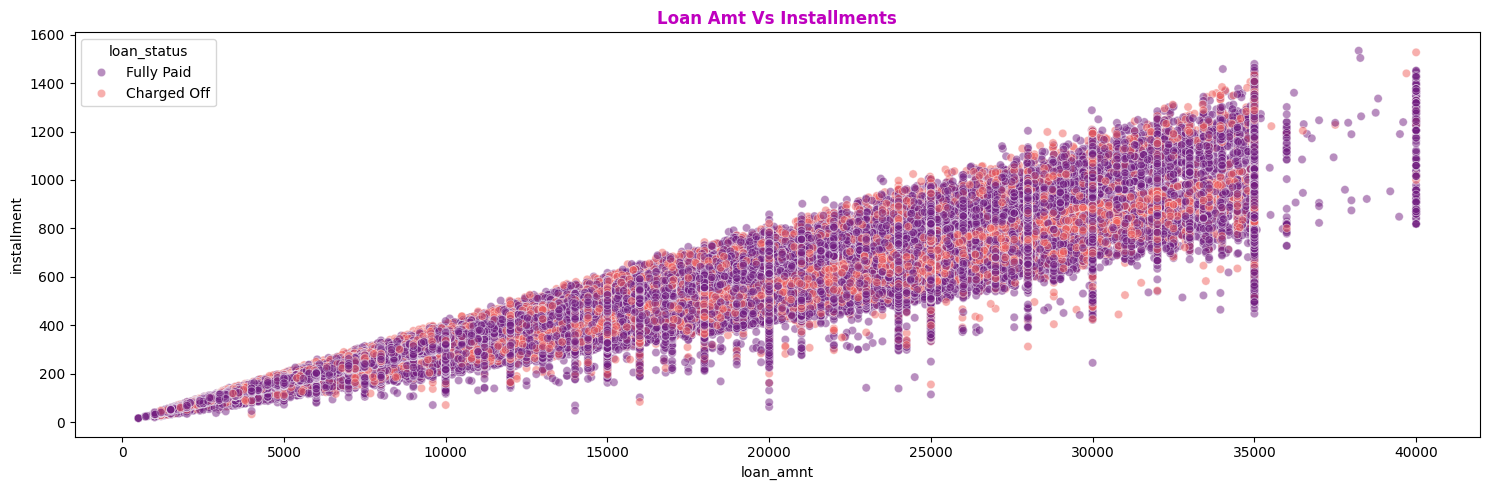

In [382]:
plt.figure(figsize = (15,5))
sns.scatterplot(data = data, x = 'loan_amnt', y = 'installment', alpha = 0.5, hue = 'loan_status', palette = "magma")
plt.title('Loan Amt Vs Installments',fontsize=12,fontweight='bold',color='m')
plt.tight_layout()
plt.show()

## Insights :
- Loan Terms: It's important to understand how loan amount and installment payments are related, as this helps lenders set suitable terms, like interest rates and repayment periods, based on a borrower’s ability to repay.

- Multicollinearity Risk: High correlation between variables like loan amount and installment payments can cause multicollinearity, leading to unstable model estimates. Techniques like variable selection or regularization may be needed to address this issue.

# Q3. The majority of people have which type of home ownership.

In [383]:
round(data['home_ownership'].value_counts(normalize=True)*100,2)

,proportion
home_ownership,
MORTGAGE,50.08
RENT,40.35
OWN,9.53
OTHER,0.03
NONE,0.01
ANY,0.00


## Insights :

- Home Ownership Distribution: Mortgage holders make up about 50.08%, while renters account for 40.35%, highlighting a large portion of individuals who either own homes through mortgages or prefer renting over owning.

# Q4. People with grades ‘A’ are more likely to fully pay their loan. (T/F)

In [384]:
round(pd.crosstab(data['grade'],data['loan_status'], normalize = 'index')*100,2)

loan_status,Charged Off,Fully Paid
grade,,
A,6.29,93.71
B,12.57,87.43
C,21.18,78.82
D,28.87,71.13
E,37.36,62.64
F,42.79,57.21
G,47.84,52.16


Loan Repayment Behavior: Borrowers with an 'A' grade have a very high repayment rate, with around 93.71% of their loans fully paid, indicating that those with the best credit ratings are more likely to meet their loan obligations.

So, Answer is True.

# Q5. Name the top 2 afforded job titles.

In [385]:
data["emp_title"].value_counts().head()

,count
emp_title,
Not Available,22927
Teacher,4389
Manager,4250
Registered Nurse,1856
RN,1846


## Top 2 most affoarded job titles are Teachers and Managers

# HeatMap

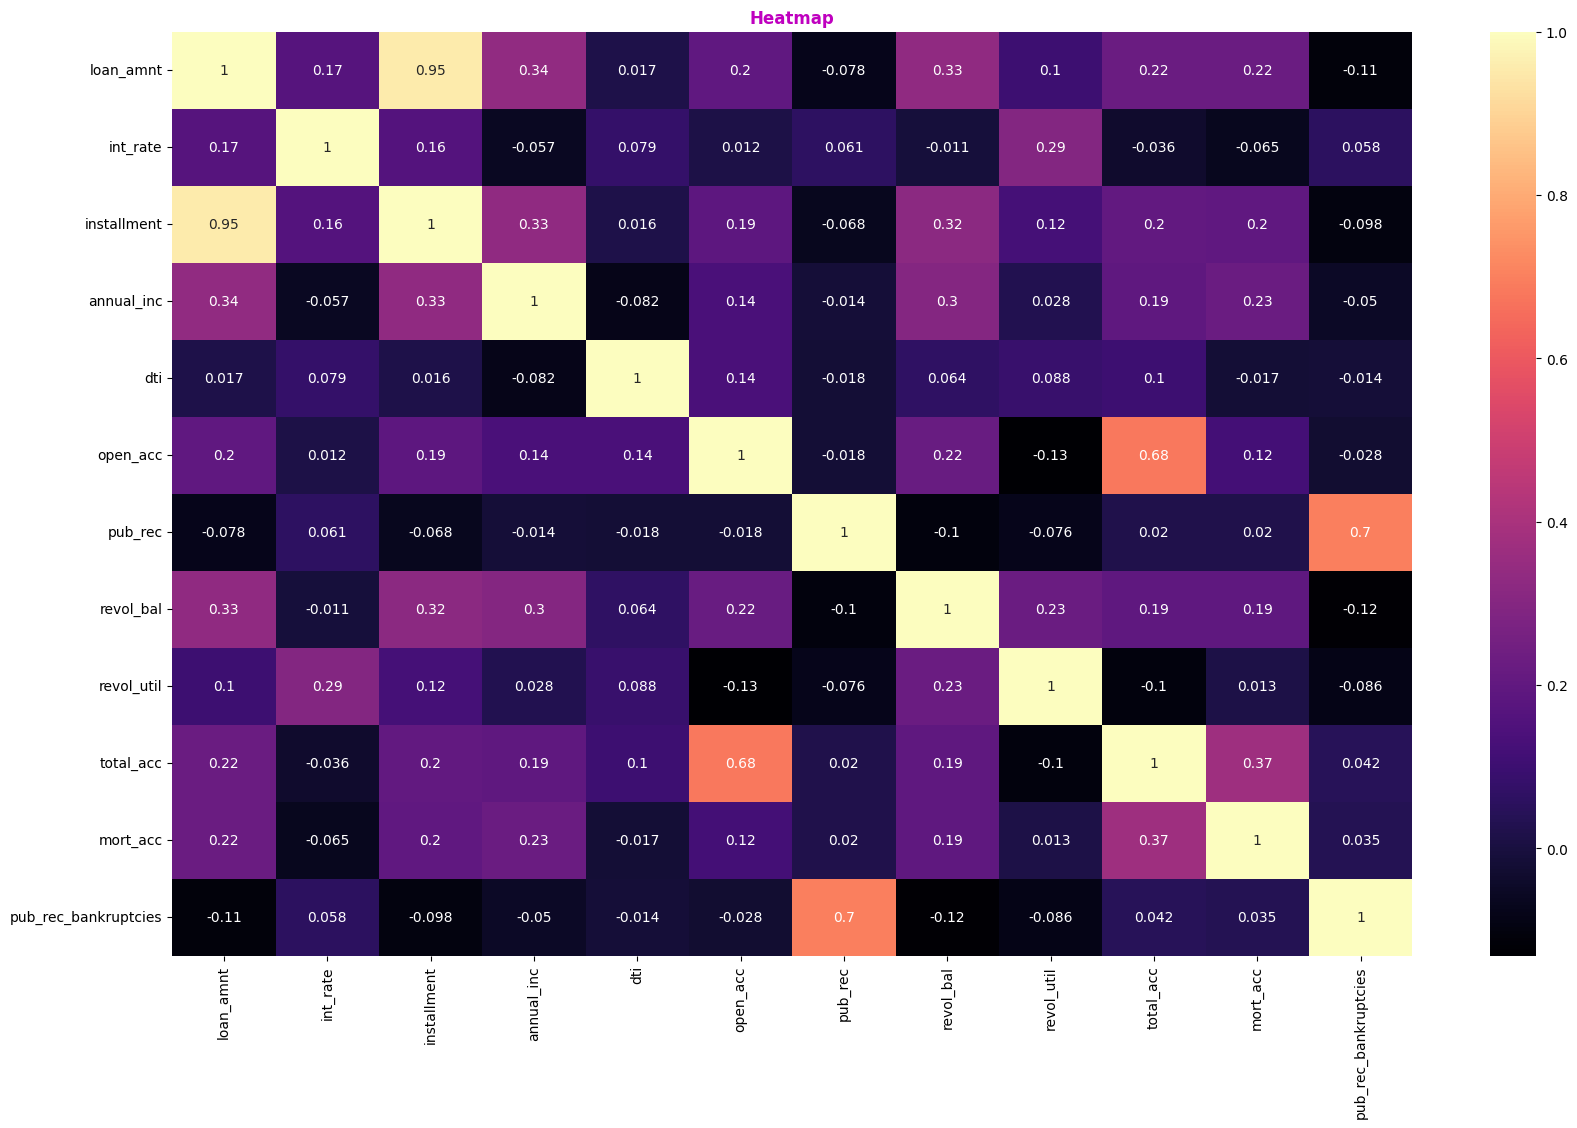

In [386]:
plt.figure(figsize=(20,12))
sns.heatmap(data.corr(numeric_only = True), annot=True, cmap='magma')
plt.title('Heatmap',fontsize=12,fontweight='bold',color='m')
plt.show()

## Insights :
- Loan Amount and Installment: A strong correlation exists between loan amount and installment, suggesting that larger loans are associated with higher installment payments.

- Credit History: Total accounts (total_acc) and open accounts (open_acc) show a significant correlation, as does the relationship between public records of bankruptcies (pub_rec_bankruptcies) and public records (pub_rec).





# Feature Engineering

In [387]:
data['pub_rec'] = [1 if i > 1 else 0 for i in data['pub_rec']]
data['mort_acc'] = [1 if i > 1 else 0 for i in data['mort_acc']]
data['pub_rec_bankruptcies'] = [1 if i > 1 else 0 for i in data['pub_rec_bankruptcies']]

In [388]:
data.head(3)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,state,pincode,issued_d_month
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10,RENT,117000.0,Not Verified,2015-01-01,Fully Paid,vacation,Vacation,26.24,1990-06-01,16.0,0,36369.0,41.8,25.0,w,INDIVIDUAL,0,0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690",OK,22690,January
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4,MORTGAGE,65000.0,Not Verified,2015-01-01,Fully Paid,debt_consolidation,Debt consolidation,22.05,2004-07-01,17.0,0,20131.0,53.3,27.0,f,INDIVIDUAL,1,0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113",SD,05113,January
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,1,RENT,43057.0,Source Verified,2015-01-01,Fully Paid,credit_card,Credit card refinancing,12.79,2007-08-01,13.0,0,11987.0,92.2,26.0,f,INDIVIDUAL,0,0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113",WV,05113,January


# Outlier Treatment

In [389]:
for i in num_col2:
  Q1 = np.quantile(data[i],0.25)
  Q3 = np.quantile(data[i],0.75)
  IQR = Q3 - Q1
  upper_bound = Q3 + (1.5*IQR)
  lower_bound = Q1 - (1.5*IQR)
  outliers = data[(data[i]< lower_bound)| (data[i]>upper_bound)]
  print('Column Name :', i)
  print(f'25th Percentile Value : {Q1} , 75th Percentile Value : {Q3} ')
  print(f'IQR Value : {IQR}')
  print(f'Lower Bound : {round(lower_bound,2)} , Upper Bound : {round(upper_bound,2)}')
  print(f"Number of Outliers : {len(outliers)}")
  print(f"Percentage Of Outliers : {(len(outliers)/len(data[i]))*100} \n")
  print("-"*80)

Column Name : loan_amnt
25th Percentile Value : 8000.0 , 75th Percentile Value : 20000.0 
IQR Value : 12000.0
Lower Bound : -10000.0 , Upper Bound : 38000.0
Number of Outliers : 191
Percentage Of Outliers : 0.04822866954523647 

--------------------------------------------------------------------------------
Column Name : int_rate
25th Percentile Value : 10.49 , 75th Percentile Value : 16.49 
IQR Value : 5.999999999999998
Lower Bound : 1.49 , Upper Bound : 25.49
Number of Outliers : 3777
Percentage Of Outliers : 0.9537156276039694 

--------------------------------------------------------------------------------
Column Name : installment
25th Percentile Value : 250.33 , 75th Percentile Value : 567.3 
IQR Value : 316.9699999999999
Lower Bound : -225.12 , Upper Bound : 1042.75
Number of Outliers : 11250
Percentage Of Outliers : 2.8406938868267555 

--------------------------------------------------------------------------------
Column Name : annual_inc
25th Percentile Value : 45000.0 , 7

## Clipping the outlier

In [390]:
# After clipping we can see the results
for i in num_col2:
  q1 =  data[i].quantile(0.25)
  q3 =  data[i].quantile(0.75)
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  data[i] = np.where(data[i] < lower_bound,lower_bound,data[i])
  data[i] = np.where(data[i] > upper_bound,upper_bound,data[i])
  outliers =data[(data[i] < lower_bound) | ( data[i] > upper_bound)]
  print(f"No.of outliers in col {i}: ",len(outliers))
  print("-"*50)

No.of outliers in col loan_amnt:  0
--------------------------------------------------
No.of outliers in col int_rate:  0
--------------------------------------------------
No.of outliers in col installment:  0
--------------------------------------------------
No.of outliers in col annual_inc:  0
--------------------------------------------------
No.of outliers in col dti:  0
--------------------------------------------------
No.of outliers in col open_acc:  0
--------------------------------------------------
No.of outliers in col pub_rec:  0
--------------------------------------------------
No.of outliers in col revol_bal:  0
--------------------------------------------------
No.of outliers in col revol_util:  0
--------------------------------------------------
No.of outliers in col total_acc:  0
--------------------------------------------------
No.of outliers in col mort_acc:  0
--------------------------------------------------
No.of outliers in col pub_rec_bankruptcies:  0
---

# Encoding

In [391]:
data['loan_status']=data.loan_status.map({'Fully Paid':1, 'Charged Off':0})

data['initial_list_status']=data.initial_list_status.map({'w':0, 'f':1})

In [392]:
data[["loan_status","initial_list_status"]].head()

,loan_status,initial_list_status
0,1,0
1,1,1
2,1,1
3,1,1
4,0,1


#Dropping Unwanted Columns

In [393]:
data2 = data.drop(columns=['emp_title','title','sub_grade','initial_list_status',
                        'state','pub_rec','pub_rec_bankruptcies','address','issued_d_month','earliest_cr_line','issue_d'],axis=1)

In [394]:
data2.sample(3)

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,revol_bal,revol_util,total_acc,application_type,mort_acc,pincode
385466,19200.0,60 months,14.16,448.35,C,8,RENT,80000.0,Source Verified,1,debt_consolidation,22.77,5.0,1449.0,13.8,38.0,INDIVIDUAL,0.0,70466
368745,18000.0,60 months,24.89,527.17,F,1,RENT,60000.0,Verified,0,debt_consolidation,29.33,11.0,15259.0,67.2,20.0,INDIVIDUAL,0.0,30723
222324,20000.0,60 months,13.99,465.27,C,10,RENT,55320.0,Not Verified,1,major_purchase,12.41,4.0,2293.0,67.4,8.0,INDIVIDUAL,0.0,29597


In [395]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            396030 non-null  float64
 1   term                 396030 non-null  object 
 2   int_rate             396030 non-null  float64
 3   installment          396030 non-null  float64
 4   grade                396030 non-null  object 
 5   emp_length           396030 non-null  object 
 6   home_ownership       396030 non-null  object 
 7   annual_inc           396030 non-null  float64
 8   verification_status  396030 non-null  object 
 9   loan_status          396030 non-null  int64  
 10  purpose              396030 non-null  object 
 11  dti                  396030 non-null  float64
 12  open_acc             396030 non-null  float64
 13  revol_bal            396030 non-null  float64
 14  revol_util           396030 non-null  float64
 15  total_acc        

In [396]:
data2.shape

(396030, 19)

In [397]:
data2["term"] = data2["term"].str.split().str[0].astype(int)

In [398]:
data2["term"]

,term
0,36
1,36
2,36
3,36
4,60
...,...
396025,60
396026,36
396027,36
396028,60


# ONE HOT ENCODING

In [399]:
dummies=['pincode', 'grade','purpose','home_ownership','verification_status','application_type']
data2_ohe = pd.get_dummies(data2, columns=dummies, drop_first=True)*1

In [400]:
data2_ohe.shape

(396030, 50)

In [401]:
data2_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 50 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            396030 non-null  float64
 1   term                                 396030 non-null  int64  
 2   int_rate                             396030 non-null  float64
 3   installment                          396030 non-null  float64
 4   emp_length                           396030 non-null  object 
 5   annual_inc                           396030 non-null  float64
 6   loan_status                          396030 non-null  int64  
 7   dti                                  396030 non-null  float64
 8   open_acc                             396030 non-null  float64
 9   revol_bal                            396030 non-null  float64
 10  revol_util                           396030 non-null  float64
 11  total_acc    

In [402]:
data2_ohe.sample(3)

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,loan_status,dti,open_acc,revol_bal,revol_util,total_acc,mort_acc,pincode_05113,pincode_11650,pincode_22690,pincode_29597,pincode_30723,pincode_48052,pincode_70466,pincode_86630,pincode_93700,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,application_type_INDIVIDUAL,application_type_JOINT
17403,5000.0,36,11.22,164.22,10,26000.0,1,21.61,10.0,5415.0,30.4,22.0,1.0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
393642,15000.0,36,11.99,498.15,10,99000.0,1,11.99,8.0,7704.0,50.4,13.0,1.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
248764,15000.0,60,18.99,389.03,3,101000.0,1,26.51,17.0,32471.0,78.6,29.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0


# Model Creation

In [403]:
X = data2_ohe.drop(['loan_status'], axis=1)
y = data2_ohe['loan_status']

In [404]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(316824, 49)
(79206, 49)
(316824,)
(79206,)


# Scaling The data

In [405]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [406]:
X_train.head()

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,open_acc,revol_bal,revol_util,total_acc,mort_acc,pincode_05113,pincode_11650,pincode_22690,pincode_29597,pincode_30723,pincode_48052,pincode_70466,pincode_86630,pincode_93700,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,application_type_INDIVIDUAL,application_type_JOINT
0,0.480000,1.0,0.264254,0.315738,1.000000,0.251115,0.649889,0.347826,0.000200,0.000779,0.476190,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,0.338000,0.0,0.556767,0.438990,0.333333,0.187380,0.055761,0.260870,0.026142,0.123053,0.114286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.920000,1.0,0.621715,0.847425,1.000000,0.506055,0.848261,0.521739,0.505817,0.447819,0.647619,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.530667,0.0,0.337134,0.645453,1.000000,0.410453,0.525537,0.782609,0.317826,0.384735,0.552381,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.920000,1.0,0.607338,0.842068,1.000000,1.000000,0.125339,0.217391,0.364186,0.491433,0.114286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [407]:
#Fit the Model on training data
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

In [408]:
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

In [409]:
lr_model.score(X_train,y_train)

0.8893675984142615

In [410]:
lr_model.score(X_test,y_test)

0.8884301694316087

Train Accuracy : 0.89
Train F1 Score: 0.94
Train Recall Score: 0.99
Train Precision Score: 0.88

Test Accuracy : 0.89
Test F1 Score: 0.93
Test Recall Score: 0.99
Test Precision Score: 0.88


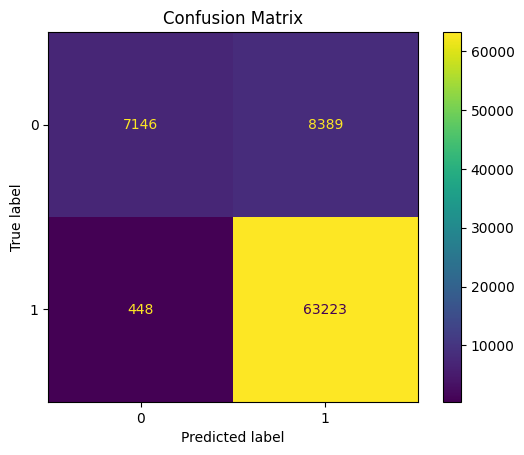

In [411]:
print('Train Accuracy :', round(lr_model.score(X_train, y_train),2))
print('Train F1 Score:',round(f1_score(y_train,y_train_pred),2))
print('Train Recall Score:',round(recall_score(y_train,y_train_pred),2))
print('Train Precision Score:',round(precision_score(y_train,y_train_pred),2))

print('\nTest Accuracy :',round(lr_model.score(X_test,y_test),2))
print('Test F1 Score:',round(f1_score(y_test,y_test_pred),2))
print('Test Recall Score:',round(recall_score(y_test,y_test_pred),2))
print('Test Precision Score:',round(precision_score(y_test,y_test_pred),2))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [412]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.46      0.62     15535
           1       0.88      0.99      0.93     63671

    accuracy                           0.89     79206
   macro avg       0.91      0.73      0.78     79206
weighted avg       0.89      0.89      0.87     79206



# Oversampling to balance the target variable

In [413]:
sm=SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train,y_train.ravel())

print(f"Before OverSampling, count of label 1: {sum(y_train == 1)}")
print(f"Before OverSampling, count of label 0: {sum(y_train == 0)}")
print(f"After OverSampling, count of label 1: {sum(y_train_res == 1)}")
print(f"After OverSampling, count of label 0: {sum(y_train_res == 0)}")

Before OverSampling, count of label 1: 254686
Before OverSampling, count of label 0: 62138
After OverSampling, count of label 1: 254686
After OverSampling, count of label 0: 254686


Train Accuracy : 0.8
Train F1 Score: 0.94
Train Recall Score: 0.99
Train Precision Score: 0.88

Test Accuracy : 0.8
Test F1 Score: 0.93
Test Recall Score: 0.99
Test Precision Score: 0.88


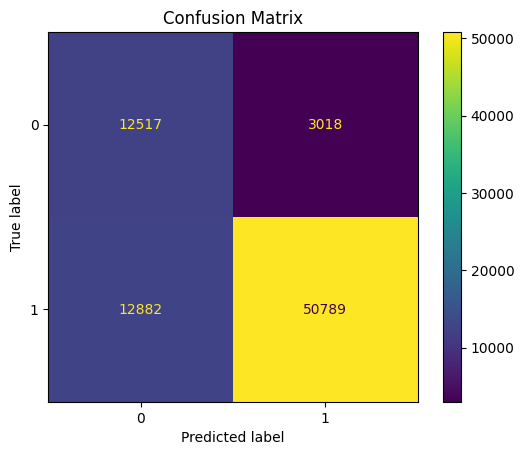

In [414]:
model = LogisticRegression()
model.fit(X_train_res, y_train_res)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

#Model Evaluation
print('Train Accuracy :', round(model.score(X_train, y_train),2))
print('Train F1 Score:',round(f1_score(y_train,y_train_pred),2))
print('Train Recall Score:',round(recall_score(y_train,y_train_pred),2))
print('Train Precision Score:',round(precision_score(y_train,y_train_pred),2))

print('\nTest Accuracy :',round(model.score(X_test,y_test),2))
print('Test F1 Score:',round(f1_score(y_test,y_test_pred),2))
print('Test Recall Score:',round(recall_score(y_test,y_test_pred),2))
print('Test Precision Score:',round(precision_score(y_test,y_test_pred),2))

# Confusion Matrix
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [415]:
y_pred = test_preds
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.49      0.81      0.61     15535
           1       0.94      0.80      0.86     63671

    accuracy                           0.80     79206
   macro avg       0.72      0.80      0.74     79206
weighted avg       0.86      0.80      0.82     79206



## Insights :
- The model achieves a high recall score, correctly identifying 80% of actual defaulters.
- However, the precision for predicting defaulters is low, as only 47% of predicted defaulters are true defaulters.
- The strong recall combined with low precision results in many false positives, meaning non-defaulters are incorrectly flagged as defaulters.
- As a result, some deserving customers may be unjustly denied loans due to the model's inability to accurately identify defaulters.
- Despite an 80% overall accuracy, the low precision negatively impacts the F1 score, bringing it down to 60%, highlighting the trade-off between precision and recall in the model's performance.

# Regularizaton Model

In [416]:
#Try with different regularization factor lamda and choose the best to build the model

lmd = np.arange(0.01, 1000, 10)

train_scores = []
test_scores = []

for i in lmd:
    model = LogisticRegression(C = 1/i)
    model.fit(X_train, y_train)

    tr_score = model.score(X_train, y_train)
    te_score = model.score(X_test, y_test)

    train_scores.append(tr_score)
    test_scores.append(te_score)

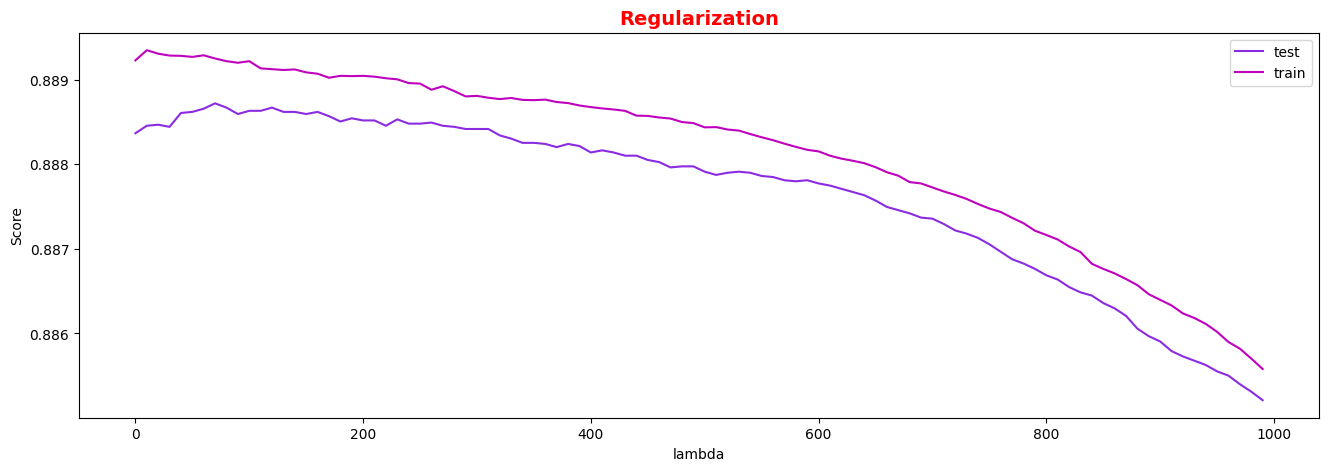

In [417]:
#Ploting the train and test scores with respect lambda values
rand = np.arange(0.01, 1000, 10)
plt.figure(figsize=(16,5))
sns.lineplot(x=rand,y=test_scores,color='blueviolet',label='test')
sns.lineplot(x=rand,y=train_scores,color='m',label='train')
plt.title('Regularization',fontsize=14,fontweight='bold',color='r')
plt.xlabel("lambda")
plt.ylabel("Score")
plt.show()

In [418]:
print(np.argmax(test_scores))
print(test_scores[np.argmax(test_scores)])

7
0.8887205514733733


In [419]:
#Calculate the best lambda value based on the index of best test score

best_lamb = 0.01 + (10*7)
best_lamb

70.01

In [420]:
#Fit the model using best lambda

reg_model = LogisticRegression(C=1/best_lamb)
reg_model.fit(X_train, y_train)

LogisticRegression(C=0.0142836737608913)

In [421]:
#Predict the y_values and y_probability values

y_reg_pred = reg_model.predict(X_test)
y_reg_pred_proba = reg_model.predict_proba(X_test)

In [422]:
#Print model score

print(f'Logistic Regression Model Score with best lambda: ',end='')
print(round(model.score(X_test, y_test)*100,2),'%')

Logistic Regression Model Score with best lambda: 88.52 %


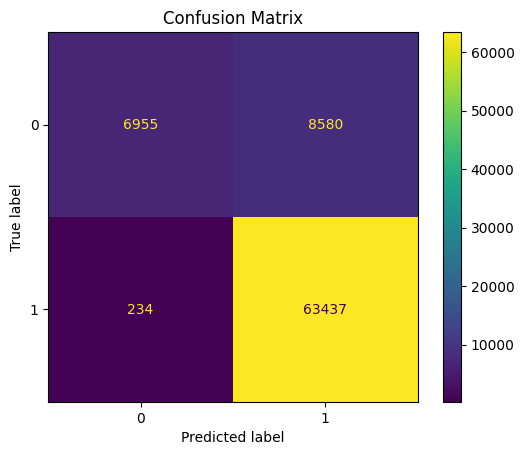

In [423]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_reg_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [424]:
print(classification_report(y_test, y_reg_pred))

              precision    recall  f1-score   support

           0       0.97      0.45      0.61     15535
           1       0.88      1.00      0.94     63671

    accuracy                           0.89     79206
   macro avg       0.92      0.72      0.77     79206
weighted avg       0.90      0.89      0.87     79206



# K-fold - Cross Validation

In [425]:
x=scaler.fit_transform(X)

kfold = KFold(n_splits=10)
accuracy = np.mean(cross_val_score(reg_model,x,y,cv=kfold,scoring='accuracy'))
print("Cross Validation accuracy : {:.3f}".format(accuracy))

Cross Validation accuracy : 0.889


In [426]:
cm = confusion_matrix(y_test, y_reg_pred)
cm_df = pd.DataFrame(cm, index=['Charged Off','Fully paid'], columns=['Charged Off','Fully paid'])
cm_df

,Charged Off,Fully paid
Charged Off,6955,8580
Fully paid,234,63437


- TN = 5223 (True Negative: Correctly predicted Charged Off)
- TP = 50450 (True Positive: Correctly predicted Fully Paid)
- FP = 6455 (False Positive: Predicted Fully Paid but actually Charged Off)
- FN = 151 (False Negative: Predicted Charged Off but actually Fully Paid)

In [427]:
#Collect the model coefficients and print those in dataframe format
coeff_df = pd.DataFrame()
coeff_df['Features'] = X_train_res.columns
coeff_df['Weights'] = model.coef_[0]
coeff_df['ABS_Weights'] = abs(coeff_df['Weights'])
coeff_df = coeff_df.sort_values(['ABS_Weights'], ascending=False)
coeff_df

,Features,Weights,ABS_Weights
13,pincode_11650,-2.483419,2.483419
20,pincode_93700,-2.482956,2.482956
19,pincode_86630,-2.464663,2.464663
15,pincode_29597,1.465068,1.465068
12,pincode_05113,1.461707,1.461707
2,int_rate,-0.783209,0.783209
6,dti,-0.608594,0.608594
5,annual_inc,0.493648,0.493648
1,term,-0.455549,0.455549
24,grade_E,-0.411222,0.411222


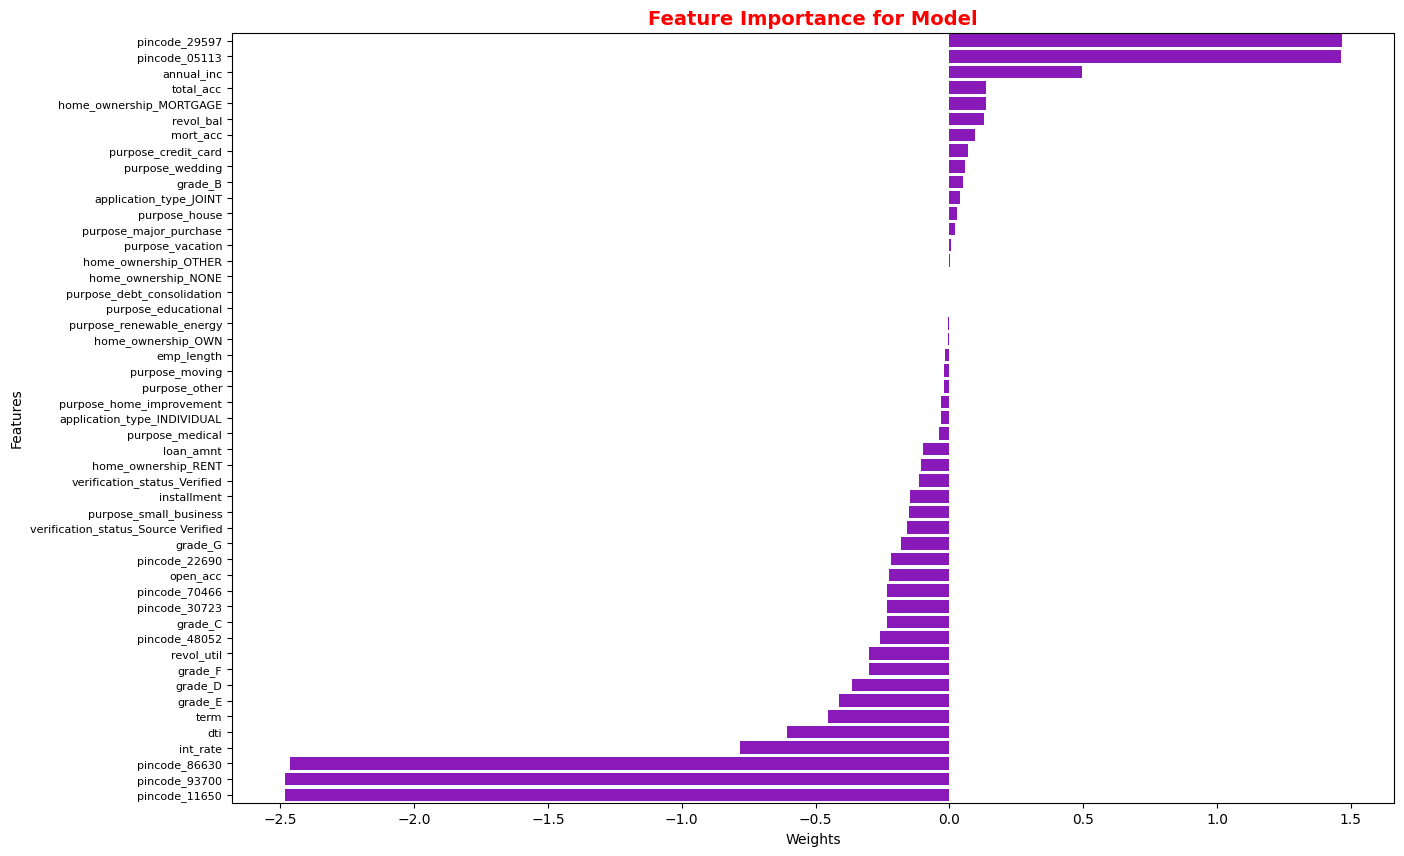

In [428]:
imp_feature = coeff_df.sort_values(by='Weights',ascending=False)
plt.figure(figsize=(15,10))
sns.barplot(y = imp_feature['Features'],x = imp_feature['Weights'],color='darkviolet')
plt.title("Feature Importance for Model",fontsize=14,fontweight='bold',color='r')
plt.xlabel("Weights")
plt.yticks(fontsize=8)
plt.ylabel("Features")
plt.show()

In [429]:
#Logistic Regression model intercept
model.intercept_

array([2.68665385])

## Insights :

- The model places significant importance on features like zip code, annual income, and grade, indicating that certain zip codes play a strong role in predicting defaulters.
- Features such as debt-to-income ratio (dti), number of open accounts (open_acc), and loan amount (loan_amnt) also have high positive coefficients, while some zip codes with negative coefficients are linked to a lower likelihood of default.




# ROC AUC Curve

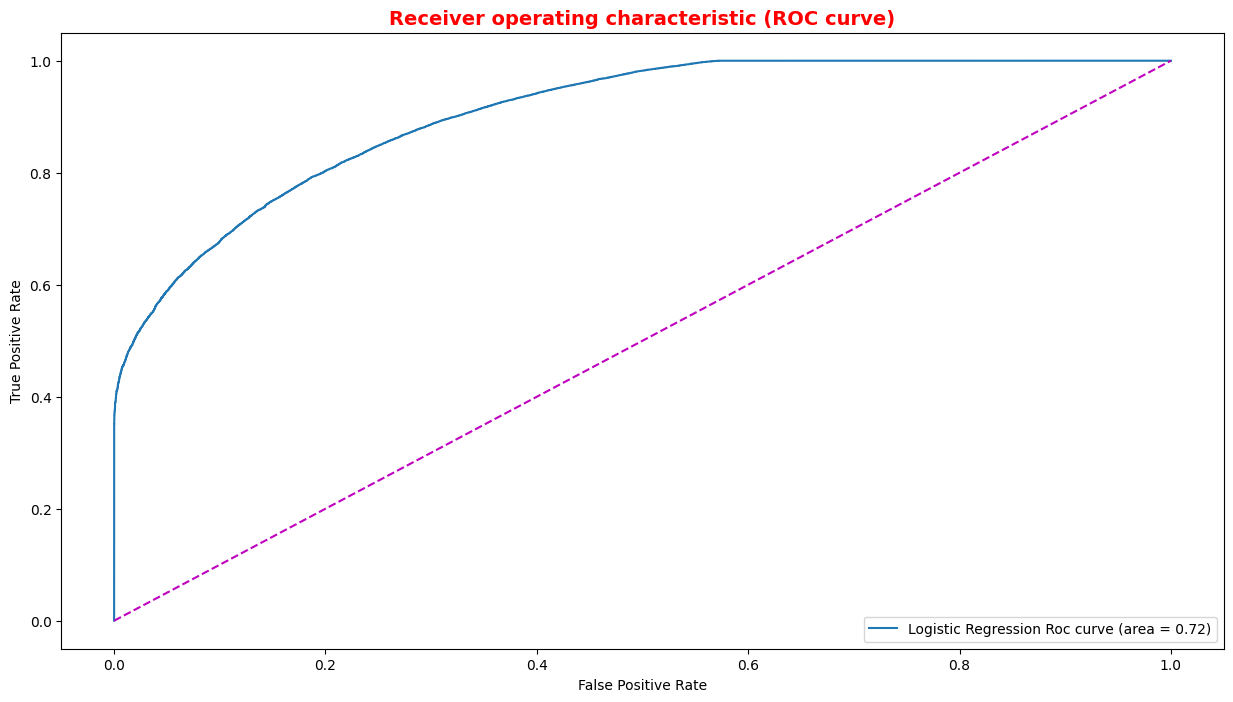

In [430]:
# area under ROC curve
logit_roc_auc = roc_auc_score(y_test,y_reg_pred)

fpr,tpr,thresholds = roc_curve(y_test,y_reg_pred_proba[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15,8))
plt.plot(fpr,tpr,label='Logistic Regression Roc curve (area = %0.2f)'% logit_roc_auc)
plt.plot([0,1],[0,1],'m--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC curve)',fontsize=14,fontweight='bold',color='r')
plt.legend(loc="lower right")
plt.show()

In [431]:
logit_roc_auc

0.7220118011201542

In [432]:
roc_auc = auc(fpr, tpr)
roc_auc

0.9040218086420752

# Insights :

- The model's ROC curve area is 72%, indicating it can distinguish between classes correctly 72% of the time.
- To improve predictions, it's important to increase the True Positive Rate (TPR) while minimizing the False Positive Rate (FPR).
- The trade-off between TPR and FPR suggests that while the model identifies more Fully Paid customers, it also risks misclassifying Charged Off customers as Fully Paid, potentially leading to Non-Performing Assets (NPAs).
- To enhance the model, reducing the FPR while keeping a high TPR is essential, which will improve the AUC and overall performance.

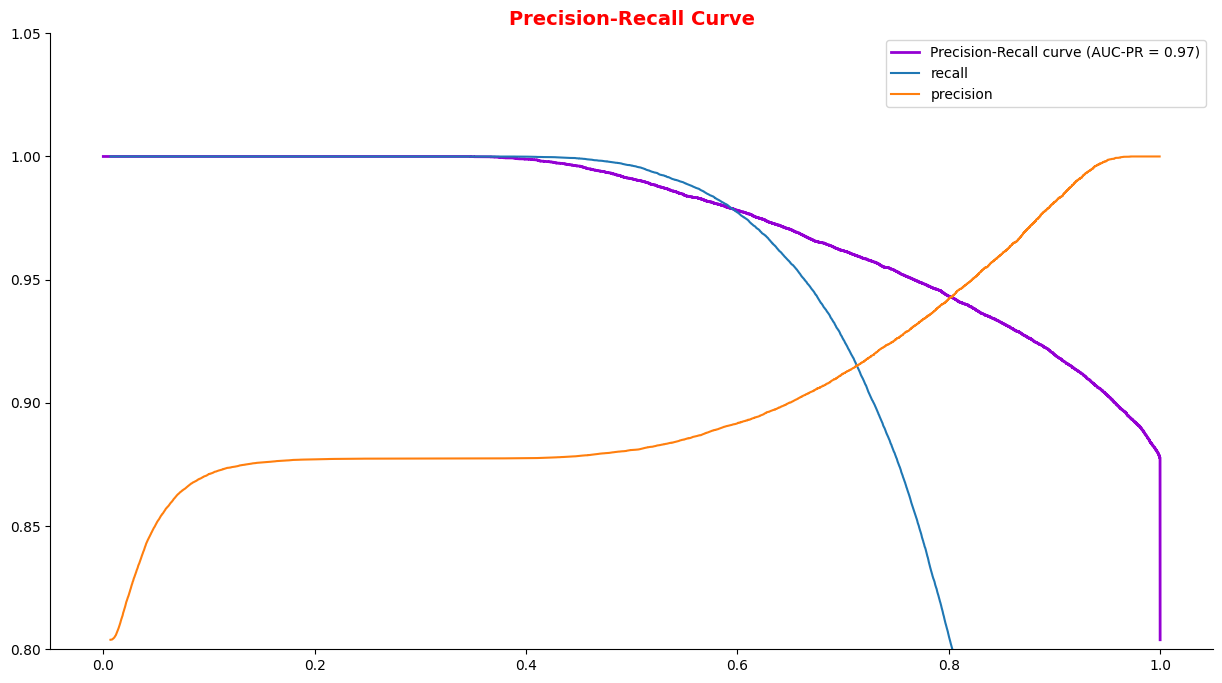

In [433]:
precision, recall, thresholds = precision_recall_curve(y_test, y_reg_pred_proba[:,1])

average_precision = average_precision_score(y_test, y_reg_pred_proba[:,1])

no_skill = len(y_test[y_test==1]) / len(y_test)

plt.figure(figsize=(15,8))
plt.plot(recall, precision, color='darkviolet', lw=2, label=f'Precision-Recall curve (AUC-PR = {average_precision:.2f})')
plt.plot(thresholds, recall[0:thresholds.shape[0]], label='recall')
plt.plot(thresholds, precision[0:thresholds.shape[0]], label='precision')
plt.ylim([0.8, 1.05])
plt.title('Precision-Recall Curve',fontsize=14,fontweight='bold',color='r')
plt.legend(loc='upper right')
sns.despine()
plt.show()

In [434]:
auc(recall, precision).round(2)

0.97

## Insights :
- The model's precision-recall curve has an AUC of 0.97, demonstrating excellent performance in distinguishing between positive and negative classes.
- Precision-recall curves are particularly useful in imbalanced datasets, focusing on the accurate identification of the relevant class, in this case, Fully Paid customers.
- Precision and recall calculations exclude true negatives, allowing for a more focused evaluation on correctly predicting Fully Paid customers.
- The high AUC value (97%) highlights the model's effectiveness in differentiating between classes, and the key area for improvement is increasing precision by reducing false positives.



# Q6: Thinking from a bank's perspective, which metric should our primary focus be on..
- ROC AUC
- Precision
- Recall
- F1 Score

### Answer:

From a bank's standpoint, reducing risks and boosting profitability are top priorities. The ROC AUC (Receiver Operating Characteristic Area Under Curve) is an essential metric as it reflects both the True Positive Rate (TPR) and False Positive Rate (FPR).


Optimizing ROC AUC helps the bank balance identifying creditworthy customers while minimizing defaulter risk, enhancing the credit model's performance.

# Q7. How does the gap in precision and recall affect the bank?

# Answer

Evaluating false positives and false negatives through recall and precision is key to understanding model errors, as a low recall poses a risk for the bank.

A larger gap between precision and recall increases incorrect predictions; good precision reduces NPAs, while good recall ensures valuable customers are not missed.

# Q8. Which were the features that heavily affected the outcome?

## Answer

Pincode, Annual Income, and Grade are the most significant features, while Loan term, total credit balance (revol_bal), debt-to-income ratio (dti), and interest rate (int_rate) also have high weights in the model.

# Q9. Will the results be affected by geographical location? (Yes/No)

## Answer

Yes, pincode (Address) is a key feature, indicating that geographical location influences our results.

# Recommendation

- To optimize loan approval and risk management, focus on maximizing the F1 score and the area under the Precision-Recall Curve, effectively balancing precision and recall to identify defaulters while minimizing false positives. This will improve the accuracy of the model and enhance risk management.

- Implement dynamic risk thresholds based on loan purpose, sub-grade analysis, and geographical data, as regional economic differences may impact the results. Additionally, increase verification rigor for applicants with lower grades, higher loan amounts, and high debt-to-income ratios (dti). Loans with lower grades should be scrutinized more carefully, and interest rates can be adjusted to compensate for higher risks.

- Consider using more advanced classifiers like Random Forests or XGBoost and fine-tuning hyperparameters to capture complex relationships within the data. Employ stratified k-fold cross-validation to ensure reliable estimates of model performance and account for minority class distribution.

- Targeted strategies can be applied for high-risk zip codes, such as additional verification steps or higher interest rates. Additionally, evaluate small business loans with extra financial health checks and collateral requirements to further mitigate default risks.
